In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from ipywidgets import interact, FloatSlider, Dropdown, fixed
from IPython.display import display

# Словарь файлов и соответствующих им названий столбцов
files = {
    'tksg.xlsx': 'TCSG',
    'yandex.xlsx': 'YDEX',
    'vk.xlsx': 'VKCO',
    'rostelecom.xlsx': 'RTKM',
    'usd_rub.xlsx': 'USD_RUB',
    'brent.xlsx': 'Brent',
    'bitcoin.xlsx': 'BTC_USD'
}


In [2]:
# 1. Импорт данных и обьединение в единый временной ряд методом inner join.
cleaned_df = None
for file, column_name in files.items():
    df = pd.read_excel(file)
    if 'Дата' not in df.columns or 'Значение' not in df.columns:
        raise KeyError(f"Столбцы 'Дата' или 'Значение' не найдены в файле {file}.")
    
    #перевод даты к пандасу и точки вместо запятых
    df['Date'] = pd.to_datetime(df['Дата'], format='%d.%m.%Y')
    df[column_name] = df['Значение'].astype(str).str.replace(' ', '').str.replace(',', '.').astype(float)
    df = df[['Date', column_name]]
    df.set_index('Date', inplace=True)
    
    #принтуем каждый файл 3head-3tail
    print(f"\nДанные из файла {file} ({column_name}):")
    print(df.head(3))
    print(df.tail(3))
    print(f"Количество строк: {len(df)}")
    
    if cleaned_df is None:
        cleaned_df = df
    else:
        cleaned_df = cleaned_df.join(df, how='inner')

cleaned_df = cleaned_df[files.values()]
cleaned_df = cleaned_df.sort_index()

print("\nОбщие данные после объединения:")
print(cleaned_df.head())
print("\nРазмер данных:", cleaned_df.shape)
print("Диапазон дат:", cleaned_df.index.min(), "по", cleaned_df.index.max())


Данные из файла tksg.xlsx (TCSG):
              TCSG
Date              
2025-04-28  3279.8
2025-04-25  3284.4
2025-04-24  3212.0
              TCSG
Date              
2019-10-30  1217.0
2019-10-29  1219.8
2019-10-28  1206.0
Количество строк: 1353

Данные из файла yandex.xlsx (YDEX):
              YDEX
Date              
2025-04-28  4283.0
2025-04-25  4371.5
2025-04-24  4293.0
              YDEX
Date              
2018-04-30  2097.5
2018-04-28  2030.0
2018-04-27  2015.5
Количество строк: 1728

Данные из файла vk.xlsx (VKCO):
             VKCO
Date             
2025-04-28  272.9
2025-04-25  283.6
2025-04-24  272.8
              VKCO
Date              
2020-07-06  1852.0
2020-07-03  1754.8
2020-07-02  1666.0
Количество строк: 1183

Данные из файла rostelecom.xlsx (RTKM):
             RTKM
Date             
2025-04-28  59.85
2025-04-25  61.47
2025-04-24  60.94
             RTKM
Date             
2015-04-03  80.70
2015-04-02  80.42
2015-04-01  80.00
Количество строк: 2531

Данные из файла 

In [6]:
# 2. Очистка от выбросов (метод IQR)
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

columns_to_clean = list(files.values())
cleaned_df = remove_outliers(cleaned_df, columns_to_clean)
print("\nДанные после очистки от выбросов:")
print(cleaned_df.head())
print("\nСтатистика после очистки:")
print(cleaned_df.describe())


Данные после очистки от выбросов:
              TCSG    YDEX   VKCO   RTKM  USD_RUB   Brent      BTC_USD
Date                                                                  
2022-02-25  3054.5  1931.2  296.0  62.27  86.9288   97.93  38914.50561
2022-04-07  3470.0  1660.0  492.0  61.50  82.5962  100.58  43584.95653
2022-04-08  3274.5  2000.0  497.8  64.41  76.2547  102.78  42788.70366
2022-04-25  1908.0  1520.8  370.6  57.21  73.5050  102.32  40159.63379
2022-07-06  2100.0  1438.0  321.0  66.67  58.5118  100.69  20308.32973

Статистика после очистки:
              TCSG         YDEX        VKCO        RTKM     USD_RUB  \
count   483.000000   483.000000  483.000000  483.000000  483.000000   
mean   2921.905383  2873.062733  489.382402   69.300104   82.944045   
std     413.572662   922.944308  131.198845   11.926368   13.185172   
min    1810.000000  1400.800000  237.800000   50.420000   56.478300   
25%    2577.950000  2030.300000  403.100000   59.150000   74.125450   
50%    2938.000

In [ ]:
# 3. Нормализация (Z-нормализация)
normalized_df = cleaned_df.copy()
for col in columns_to_clean:
    mean = cleaned_df[col].mean()
    std = cleaned_df[col].std()
    normalized_df[col] = (cleaned_df[col] - mean) / std
    print(f"\nСтатистика для {col} (до нормализации): mean = {mean:.2f}, std = {std:.2f}")

print("\nПример нормализованного датафрейма (первые 5 строк):")
print(normalized_df.head())



Статистика для TCSG (до нормализации): mean = 2902.33, std = 448.82

Статистика для YDEX (до нормализации): mean = 2835.33, std = 926.73

Статистика для VKCO (до нормализации): mean = 485.42, std = 130.15

Статистика для RTKM (до нормализации): mean = 68.97, std = 11.84

Статистика для USD_RUB (до нормализации): mean = 82.23, std = 13.43

Статистика для Brent (до нормализации): mean = 83.20, std = 8.99

Статистика для BTC_USD (до нормализации): mean = 45019.13, std = 26906.11

Пример нормализованного датафрейма (первые 5 строк):
                TCSG      YDEX      VKCO      RTKM   USD_RUB     Brent  \
Date                                                                     
2022-02-21  3.504037  0.248687 -0.502677 -0.497093 -0.481578  1.356637   
2022-02-22  3.534116  0.344724 -0.043210 -0.087423 -0.406717  1.517996   
2022-02-25  0.339048 -0.975616 -1.455417 -0.566356  0.350058  1.639293   
2022-04-01  1.330544  1.774481  0.543802 -0.250446  0.087979  2.358175   
2022-04-04  1.697063

In [35]:
# 1. Проверка нормальности и характеристик распределения
factors = ['TCSG', 'YDEX', 'VKCO', 'RTKM', 'USD_RUB', 'Brent', 'BTC_USD']
normality_results = []
distribution_stats = []

for factor in factors:
    data = normalized_df[factor].dropna()
    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(data)
    conclusion = "Не соответствует нормальному распределению" if p_value < 0.05 else "Соответствует нормальному распределению"
    normality_results.append([factor, stat, p_value, conclusion])

    # Характеристики распределения
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    mean = data.mean()
    median = data.median()
    std = data.std()
    min_val = data.min()
    max_val = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    # Интерпретация асимметрии
    skewness_comment = (
        "Сильная правосторонняя асимметрия" if skewness > 1 else
        "Сильная левосторонняя асимметрия" if skewness < -1 else
        "Умеренная асимметрия" if abs(skewness) > 0.5 else
        "Приблизительно симметричное распределение"
    )
    
    # Интерпретация куртозиса
    kurtosis_comment = (
        "Тяжёлые хвосты (много выбросов)" if kurtosis > 3 else
        "Лёгкие хвосты (меньшая вероятность экстремальных значений, что положительно для моделирования)" if kurtosis < -1 else
        "Нормальные хвосты (умеренное количество выбросов)"
    )
    
    # Дополнительные комментарии для факторов
    factor_comment = (
        "Высокая волатильность из-за влияния криптовалютного рынка и санкций." if factor == 'TCSG' else
        "Зависимость от сырьевых рынков (нефть) и макроэкономической среды." if factor in ['YDEX', 'VKCO', 'RTKM'] else
        "Волатильность связана с экономическими и геополитическими факторами." if factor == 'USD_RUB' else
        "Зависимость от мировых сырьевых рынков." if factor == 'Brent' else
        "Высокая волатильность из-за спекулятивного характера криптовалют."
    )
    
    distribution_stats.append([
        factor, mean, median, std, skewness, kurtosis, min_val, max_val, q1, q3,
        skewness_comment, kurtosis_comment, factor_comment
    ])

# Формирование таблиц результатов
normality_df = pd.DataFrame(normality_results, columns=['Фактор', 'Статистика Шапиро-Уилка', 'p-value', 'Нормальность'])
dist_stats_df = pd.DataFrame(distribution_stats, columns=[
    'Фактор', 'Среднее', 'Медиана', 'Стд. откл.', 'Асимметрия', 'Куртозис',
    'Мин.', 'Макс.', 'Q1', 'Q3', 'Асимметрия (пояснение)', 'Куртозис (пояснение)', 'Комментарий'
]).round(4)

# Сохранение таблиц
normality_df.to_excel('normality_results.xlsx', index=False)
dist_stats_df.to_excel('distribution_stats.xlsx', index=False)

# Вывод таблиц
print("\nРезультаты теста Шапиро-Уилка:")
print(normality_df.to_string(index=False))
print("\nХарактеристики распределения:")
print(dist_stats_df.to_string(index=False))


Результаты теста Шапиро-Уилка:
 Фактор  Статистика Шапиро-Уилка      p-value                               Нормальность
   TCSG                 0.962123 8.969584e-13 Не соответствует нормальному распределению
   YDEX                 0.912955 5.278621e-20 Не соответствует нормальному распределению
   VKCO                 0.724136 5.782622e-33 Не соответствует нормальному распределению
   RTKM                 0.916432 1.312382e-19 Не соответствует нормальному распределению
USD_RUB                 0.972351 1.688694e-10 Не соответствует нормальному распределению
  Brent                 0.950961 7.906556e-15 Не соответствует нормальному распределению
BTC_USD                 0.893201 4.719772e-22 Не соответствует нормальному распределению

Характеристики распределения:
 Фактор  Среднее  Медиана  Стд. откл.  Асимметрия  Куртозис    Мин.  Макс.      Q1      Q3                    Асимметрия (пояснение)                                                                           Куртозис (пояснени

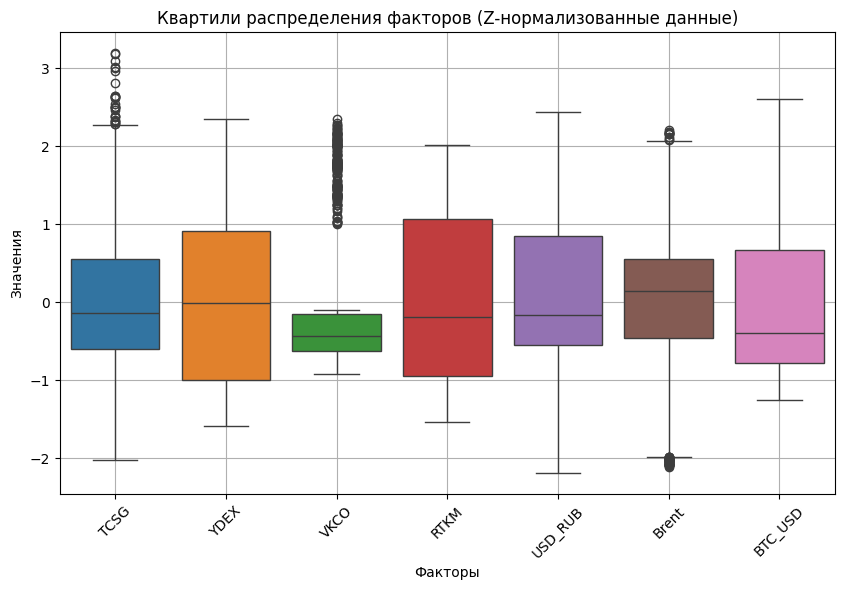


Предупреждение: Линейная регрессия может быть менее надежной из-за ненормального распределения данных. Рекомендуется рассмотреть нелинейные модели для повышения точности.

Результаты регрессии с пояснениями (на тестовой выборке):
Каждая строка показывает, как макроэкономические факторы влияют на цену акций компании.
- USD_RUB (β1): Влияние курса доллара к рублю (положительное или отрицательное).
- Brent (β2): Влияние цены нефти (обычно отрицательное для цифрового сектора).
- BTC_USD (β3): Влияние цены биткоина (положительное для TCSG и YDEX).
- Intercept: Базовая цена акций при нулевых факторах (Z-нормализована).
- MAE: Средняя абсолютная ошибка (чем меньше, тем точнее модель).
- MSE: Средняя квадратичная ошибка (показывает разброс ошибок).
Примечание: Регрессионные коэффициенты для USD_RUB противоречат корреляциям Спирмена, что указывает на нелинейные зависимости и может снижать точность линейной модели.
Компания  USD_RUB (β1)  Brent (β2)  BTC_USD (β3)  Intercept    MAE    MSE
    TC

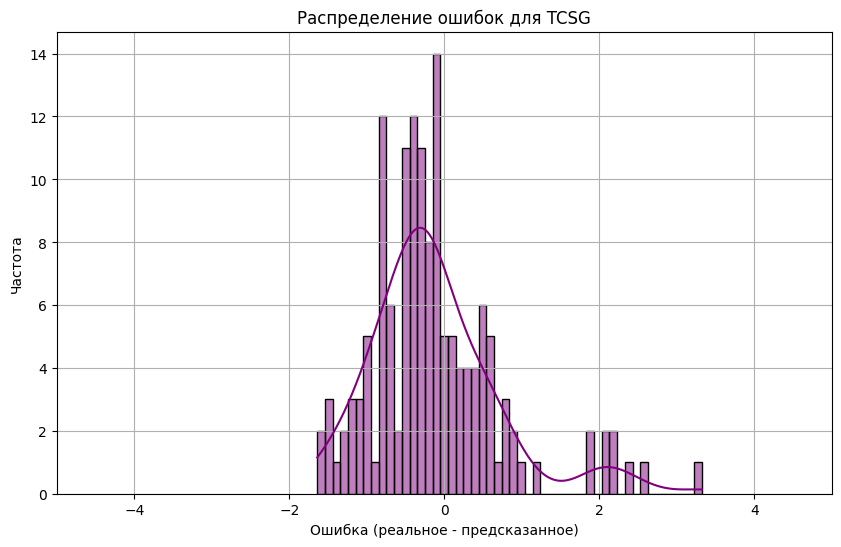


Характеристики ошибок для YDEX:
- Среднее: Ошибки в среднем близки к нулю (среднее: -0.0374).
- Стандартное отклонение: Умеренная вариабельность ошибок (стандартное отклонение: 0.5632). Умеренная вариабельность указывает на ограниченную точность модели, особенно для RTKM.
- Асимметрия: Ошибки симметричны (значение: 0.2852)
- Куртозис: Нормальные хвосты ошибок (значение: 0.5363)
- Шапиро-Уилка: stat=0.9769, p=0.0143, Ошибки не соответствуют нормальному распределению


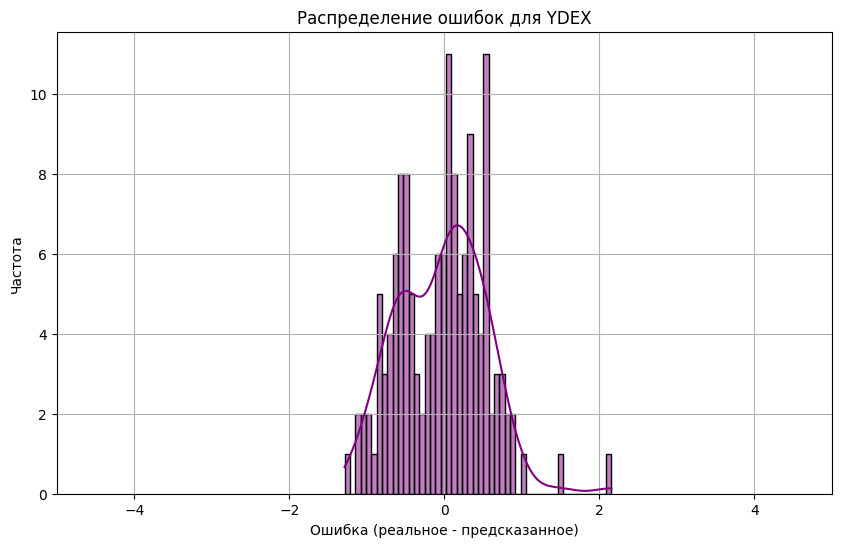


Характеристики ошибок для VKCO:
- Среднее: Ошибки в среднем близки к нулю (среднее: -0.0214).
- Стандартное отклонение: Умеренная вариабельность ошибок (стандартное отклонение: 0.5134). Умеренная вариабельность указывает на ограниченную точность модели, особенно для RTKM.
- Асимметрия: Ошибки симметричны (значение: 0.2284)
- Куртозис: Нормальные хвосты ошибок (значение: -0.6471)
- Шапиро-Уилка: stat=0.9815, p=0.0466, Ошибки не соответствуют нормальному распределению


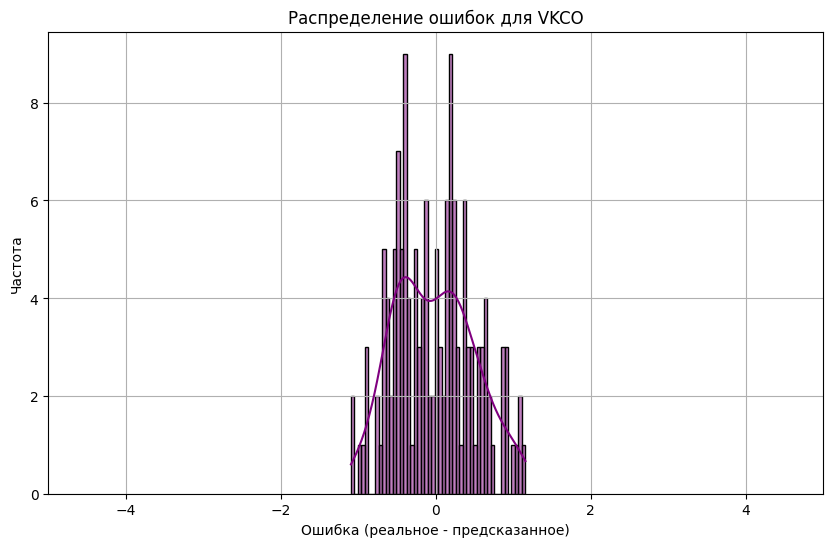


Характеристики ошибок для RTKM:
- Среднее: Ошибки в среднем близки к нулю (среднее: -0.0923).
- Стандартное отклонение: Умеренная вариабельность ошибок (стандартное отклонение: 0.7452). Умеренная вариабельность указывает на ограниченную точность модели, особенно для RTKM.
- Асимметрия: Ошибки симметричны (значение: 0.4367)
- Куртозис: Нормальные хвосты ошибок (значение: 0.0064)
- Шапиро-Уилка: stat=0.9669, p=0.0013, Ошибки не соответствуют нормальному распределению


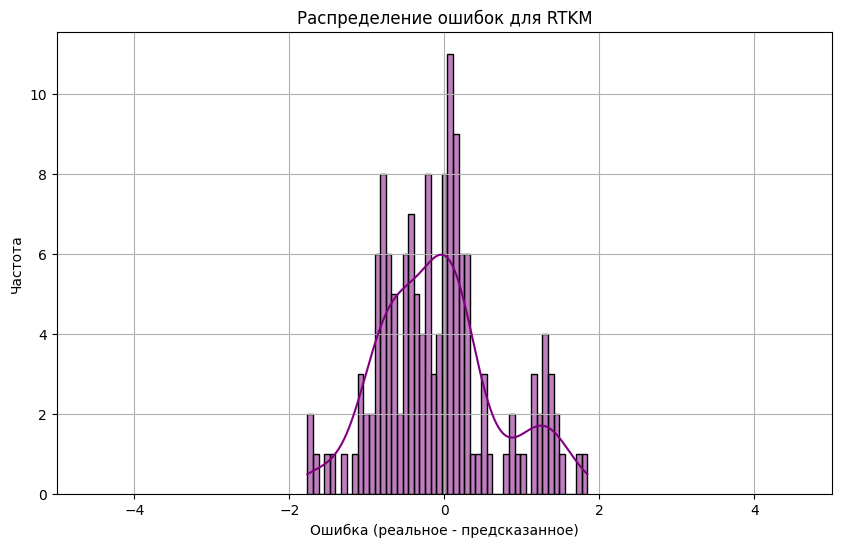


Вывод ANOVA с замечаниями:
Высокая остаточная дисперсия, особенно для RTKM, указывает на ограничения модели. Добавление факторов (например, процентных ставок) может улучшить объяснительную способность.
Для USD_RUB в RTKM (p=0.0373) значимость на грани (p ≈ 0.05), что требует осторожной интерпретации.

Результаты ANOVA для TCSG с пояснениями:
ANOVA показывает, насколько каждый фактор объясняет вариацию цен акций.
- Source: Фактор (USD_RUB, Brent, BTC_USD) или остаточная вариация (Residual).
- sum_sq: Доля вариации, объясненная фактором (чем больше, тем сильнее влияние).
- df: Степени свободы (1 для факторов, 904 для остатков).
- F: F-статистика (чем выше, тем значимее фактор).
- PR(>F): p-значение (если p < 0.05, фактор значим).
    sum_sq    df         F       PR(>F)
  4.191016   1.0  4.773351 2.922345e-02
  9.650644   1.0 10.991585 9.608837e-04
 24.793849   1.0 28.238912 1.429097e-07
635.674160 724.0       NaN          NaN

Результаты ANOVA для YDEX с пояснениями:
ANOVA показывает, н

interactive(children=(Dropdown(description='Тип данных:', index=1, options=('Z-нормализованные', 'Реальные (ру…

<function __main__.update_sliders(data_type)>

In [ ]:
# Список переменных
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
independent_vars = ['USD_RUB', 'Brent', 'BTC_USD']

# Boxplot для визуализации квартилей
plt.figure(figsize=(10, 6))
sns.boxplot(data=normalized_df[factors])
plt.title('Квартили распределения факторов (Z-нормализованные данные)')
plt.xlabel('Факторы')
plt.ylabel('Значения')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('boxplot_factors.png', bbox_inches='tight')
plt.show()

# 2. Модель регрессии на нормализованных данных с разбиением на обучающую и тестовую выборки
print("\nПредупреждение: Линейная регрессия может быть менее надежной из-за ненормального распределения данных. Рекомендуется рассмотреть нелинейные модели для повышения точности.")
results_normalized = {}
X_normalized = normalized_df[independent_vars].dropna()

for y_var in dependent_vars:
    y = normalized_df[y_var].dropna()
    common_index = X_normalized.index.intersection(y.index)
    X_subset = X_normalized.loc[common_index]
    y_subset = y.loc[common_index]
    
    # Разбиение данных на обучающую (80%) и тестовую (20%) выборки
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
    
    # Обучение модели на обучающей выборке
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Предсказания на тестовой выборке
    y_pred = model.predict(X_test)
    
    # Вычисление метрик на тестовой выборке
    mae = np.mean(np.abs(y_test - y_pred))
    mse = np.mean((y_test - y_pred) ** 2)
    
    results_normalized[y_var] = {
        'y_actual': y_test,
        'y_pred': y_pred,
        'X_test': X_test,
        'coefficients': dict(zip(independent_vars, model.coef_)),
        'intercept': model.intercept_,
        'MAE': mae,
        'MSE': mse
    }

# Формирование таблицы регрессии
results_data = []
for y_var in dependent_vars:
    coeffs = results_normalized[y_var]['coefficients']
    results_data.append([
        y_var,
        coeffs.get('USD_RUB', 0),
        coeffs.get('Brent', 0),
        coeffs.get('BTC_USD', 0),
        results_normalized[y_var]['intercept'],
        results_normalized[y_var]['MAE'],
        results_normalized[y_var]['MSE']
    ])
results_df = pd.DataFrame(
    results_data,
    columns=['Компания', 'USD_RUB (β1)', 'Brent (β2)', 'BTC_USD (β3)', 'Intercept', 'MAE', 'MSE']
).round(4)

# Вывод результатов регрессии с пояснениями
print("\nРезультаты регрессии с пояснениями (на тестовой выборке):")
print("Каждая строка показывает, как макроэкономические факторы влияют на цену акций компании.")
print("- USD_RUB (β1): Влияние курса доллара к рублю (положительное или отрицательное).")
print("- Brent (β2): Влияние цены нефти (обычно отрицательное для цифрового сектора).")
print("- BTC_USD (β3): Влияние цены биткоина (положительное для TCSG и YDEX).")
print("- Intercept: Базовая цена акций при нулевых факторах (Z-нормализована).")
print("- MAE: Средняя абсолютная ошибка (чем меньше, тем точнее модель).")
print("- MSE: Средняя квадратичная ошибка (показывает разброс ошибок).")
print("Примечание: Регрессионные коэффициенты для USD_RUB противоречат корреляциям Спирмена, что указывает на нелинейные зависимости и может снижать точность линейной модели.")
print(results_df.to_string(index=False))

# 3. Анализ ошибок регрессии
print("\nАнализ ошибок регрессии (на тестовой выборке):")
print("Симметричность и нормальные/лёгкие хвосты ошибок свидетельствуют, что модель хорошо предсказывает центральную часть данных, но может хуже улавливать экстремальные значения, что ожидаемо для линей eveniment на ненормальных данных.")
for y_var in dependent_vars:
    errors = results_normalized[y_var]['y_actual'] - results_normalized[y_var]['y_pred']
    error_mean = errors.mean()
    error_std = errors.std()
    error_skewness = stats.skew(errors)
    error_kurtosis = stats.kurtosis(errors)
    
    # Тест Шапиро-Уилка для ошибок
    stat, p = stats.shapiro(errors)
    normality_comment = "Ошибки не соответствуют нормальному распределению" if p < 0.05 else "Ошибки соответствуют нормальному распределению"
    
    # Интерпретация ошибок
    error_mean_comment = (
        f"Ошибки в среднем {'смещены вверх' if error_mean > 0.1 else 'смещены вниз' if error_mean < -0.1 else 'близки к нулю'} "
        f"(среднее: {error_mean:.4f})."
    )
    error_std_comment = (
        f"{'Высокая вариабельность ошибок' if error_std > 1 else 'Умеренная вариабельность ошибок' if error_std > 0.5 else 'Низкая вариабельность ошибок'} "
        f"(стандартное отклонение: {error_std:.4f}). Умеренная вариабельность указывает на ограниченную точность модели, особенно для RTKM."
    )
    error_skewness_comment = (
        "Сильная правосторонняя асимметрия ошибок" if error_skewness > 1 else
        "Сильная левосторонняя асимметрия ошибок" if error_skewness < -1 else
        "Умеренная асимметрия ошибок" if abs(error_skewness) > 0.5 else
        "Ошибки симметричны"
    )
    error_kurtosis_comment = (
        "Тяжёлые хвосты ошибок (много выбросов)" if error_kurtosis > 3 else
        "Лёгкие хвосты ошибок (меньшая вероятность экстремальных значений)" if error_kurtosis < -1 else
        "Нормальные хвосты ошибок"
    )
    
    # Вывод характеристик ошибок
    print(f"\nХарактеристики ошибок для {y_var}:")
    print(f"- Среднее: {error_mean_comment}")
    print(f"- Стандартное отклонение: {error_std_comment}")
    print(f"- Асимметрия: {error_skewness_comment} (значение: {error_skewness:.4f})")
    print(f"- Куртозис: {error_kurtosis_comment} (значение: {error_kurtosis:.4f})")
    print(f"- Шапиро-Уилка: stat={stat:.4f}, p={p:.4f}, {normality_comment}")
    
    # Гистограмма ошибок
    plt.figure()
    sns.histplot(errors, kde=True, bins=50, color='purple')
    plt.title(f'Распределение ошибок для {y_var}')
    plt.xlabel('Ошибка (реальное - предсказанное)')
    plt.ylabel('Частота')
    plt.xlim(-5, 5)
    plt.grid(True)
    plt.savefig(f'error_histogram_{y_var}.png', bbox_inches='tight')
    plt.show()

# 4. ANOVA анализ
print("\nВывод ANOVA с замечаниями:")
print("Высокая остаточная дисперсия, особенно для RTKM, указывает на ограничения модели. Добавление факторов (например, процентных ставок) может улучшить объяснительную способность.")
print("Для USD_RUB в RTKM (p=0.0373) значимость на грани (p ≈ 0.05), что требует осторожной интерпретации.")
results_anova = {}
for y_var in dependent_vars:
    data = normalized_df[[y_var] + independent_vars].dropna()
    formula = f'{y_var} ~ USD_RUB + Brent + BTC_USD'
    model = ols(formula, data=data).fit()
    anova_table = anova_lm(model, typ=2)
    results_anova[y_var] = anova_table

    print(f"\nРезультаты ANOVA для {y_var} с пояснениями:")
    print("ANOVA показывает, насколько каждый фактор объясняет вариацию цен акций.")
    print("- Source: Фактор (USD_RUB, Brent, BTC_USD) или остаточная вариация (Residual).")
    print("- sum_sq: Доля вариации, объясненная фактором (чем больше, тем сильнее влияние).")
    print("- df: Степени свободы (1 для факторов, 904 для остатков).")
    print("- F: F-статистика (чем выше, тем значимее фактор).")
    print("- PR(>F): p-значение (если p < 0.05, фактор значим).")
    print(results_anova[y_var].to_string(index=False))

# 5. Модель для ненормализованных данных (рублях) с разбиением на обучающую и тестовую выборки
def train_ruble_model():
    X_ruble = cleaned_df[independent_vars].dropna()
    results_ruble = {}
    
    for y_var in dependent_vars:
        y = cleaned_df[y_var].dropna()
        common_index = X_ruble.index.intersection(y.index)
        X_subset = X_ruble.loc[common_index]
        y_subset = y.loc[common_index]
        
        # Разбиение данных на обучающую (80%) и тестовую (20%) выборки
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
        
        # Обучение модели на обучающей выборке
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)
        
        # Вычисление метрик на тестовой выборке
        mae = np.mean(np.abs(y_test - y_pred))
        mse = np.mean((y_test - y_pred) ** 2)
        
        results_ruble[y_var] = {
            'y_actual': y_test,
            'y_pred': y_pred,
            'X_test': X_test,
            'coefficients': dict(zip(independent_vars, model.coef_)),
            'intercept': model.intercept_,
            'MAE': mae,
            'MSE': mse
        }
    return results_ruble

results_ruble = train_ruble_model()

# 6. Интерактивная визуализация с переключателем
def predict_prices(usd_rub, brent, btc_usd, data_type):
    predictions = {}
    if data_type == 'Z-нормализованные':
        results = results_normalized
        # Нормализация факторов
        usd_rub_norm = (usd_rub - cleaned_df['USD_RUB'].mean()) / cleaned_df['USD_RUB'].std()
        brent_norm = (brent - cleaned_df['Brent'].mean()) / cleaned_df['Brent'].std()
        btc_usd_norm = (btc_usd - cleaned_df['BTC_USD'].mean()) / cleaned_df['BTC_USD'].std()
        ylabel = 'Цена акций (Z-нормализованная)'
    else:
        results = results_ruble
        usd_rub_norm = usd_rub
        brent_norm = brent
        btc_usd_norm = btc_usd
        ylabel = 'Цена акций (рубли)'
    
    for y_var in dependent_vars:
        model_coefs = results[y_var]['coefficients']
        intercept = results[y_var]['intercept']
        prediction = (intercept +
                      model_coefs['USD_RUB'] * usd_rub_norm +
                      model_coefs['Brent'] * brent_norm +
                      model_coefs['BTC_USD'] * btc_usd_norm)
        if data_type == 'Реальные (рубли)':
            prediction = max(0, prediction)  # Цены акций не могут быть отрицательными
        predictions[y_var] = prediction
    return predictions, ylabel, usd_rub_norm, brent_norm, btc_usd_norm

def update_plot(usd_rub, brent, btc_usd, data_type):
    try:
        predictions, ylabel, usd_rub_norm, brent_norm, btc_usd_norm = predict_prices(usd_rub, brent, btc_usd, data_type)
        print(f"\nПредсказания ({data_type}):", {k: round(v, 2) for k, v in predictions.items()})
        
        # Визуализация барплота
        plt.figure()
        companies = list(predictions.keys())
        values = [predictions[company] for company in companies]
        bars = plt.bar(companies, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title(f'Прогнозируемые цены акций ({data_type})', fontsize=14)
        plt.xlabel('Компания')
        plt.ylabel(ylabel)
        plt.grid(True, axis='y')
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, value + 0.02 * value, f'{value:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(f'prediction_{data_type.lower().replace(" ", "_")}_barplot.png', bbox_inches='tight')
        plt.show()

        # Отладочный вывод коэффициентов
        print(f"\nКоэффициенты модели ({data_type}):")
        for y_var in dependent_vars:
            results = results_normalized if data_type == 'Z-нормализованные' else results_ruble[y_var]
            print(f"{y_var}:")
            print(f"  USD_RUB: {results['coefficients']['USD_RUB']:.4f}")
            print(f"  Brent: {results['coefficients']['Brent']:.4f}")
            print(f"  BTC_USD: {results['coefficients']['BTC_USD']:.4f}")
            print(f"  Intercept: {results['intercept']:.4f}")
    except Exception as e:
        print(f"Ошибка в интерактивной визуализации: {e}")

# Ползунки для реальных данных
usd_rub_slider_ruble = FloatSlider(
    min=cleaned_df['USD_RUB'].min(), max=cleaned_df['USD_RUB'].max(), step=0.1,
    value=cleaned_df['USD_RUB'].mean(), description='USD/RUB (рубли):'
)
brent_slider_ruble = FloatSlider(
    min=cleaned_df['Brent'].min(), max=cleaned_df['Brent'].max(), step=0.1,
    value=cleaned_df['Brent'].mean(), description='Brent (долл./барр.):'
)
btc_usd_slider_ruble = FloatSlider(
    min=cleaned_df['BTC_USD'].min(), max=cleaned_df['BTC_USD'].max(), step=100,
    value=cleaned_df['BTC_USD'].mean(), description='BTC/USD (долл.):'
)

# Ползунки для Z-нормализованных данных
usd_rub_slider_norm = FloatSlider(
    min=normalized_df['USD_RUB'].min(), max=normalized_df['USD_RUB'].max(), step=0.1,
    value=normalized_df['USD_RUB'].mean(), description='USD/RUB (Z-норм):'
)
brent_slider_norm = FloatSlider(
    min=normalized_df['Brent'].min(), max=normalized_df['Brent'].max(), step=0.1,
    value=normalized_df['Brent'].mean(), description='Brent (Z-норм):'
)
btc_usd_slider_norm = FloatSlider(
    min=normalized_df['BTC_USD'].min(), max=normalized_df['BTC_USD'].max(), step=0.1,
    value=normalized_df['BTC_USD'].mean(), description='BTC/USD (Z-норм):'
)

# Переключатель типа данных
data_type_dropdown = Dropdown(
    options=['Z-нормализованные', 'Реальные (рубли)'],
    value='Реальные (рубли)',
    description='Тип данных:'
)

def update_sliders(data_type):
    if data_type == 'Z-нормализованные':
        interact(
            update_plot,
            usd_rub=usd_rub_slider_norm,
            brent=brent_slider_norm,
            btc_usd=btc_usd_slider_norm,
            data_type=fixed(data_type)
        )
    else:
        interact(
            update_plot,
            usd_rub=usd_rub_slider_ruble,
            brent=brent_slider_ruble,
            btc_usd=btc_usd_slider_ruble,
            data_type=fixed(data_type)
        )

interact(update_sliders, data_type=data_type_dropdown)


Результаты теста Шапиро-Уилка:
 Фактор  Статистика Шапиро-Уилка      p-value                               Нормальность
   TCSG                 0.962388 1.556980e-14 Не соответствует нормальному распределению
   YDEX                 0.922211 3.117971e-21 Не соответствует нормальному распределению
   VKCO                 0.817431 7.383052e-31 Не соответствует нормальному распределению
   RTKM                 0.928064 1.910697e-20 Не соответствует нормальному распределению
USD_RUB                 0.957361 1.362451e-15 Не соответствует нормальному распределению
  Brent                 0.977189 1.009165e-10 Не соответствует нормальному распределению
BTC_USD                 0.960226 5.320527e-15 Не соответствует нормальному распределению

Характеристики распределения:
 Фактор  Среднее  Медиана  Стд. откл.  Асимметрия  Куртозис    Мин.  Макс.      Q1     Q3                    Асимметрия (пояснение)                                                                           Куртозис (пояснение

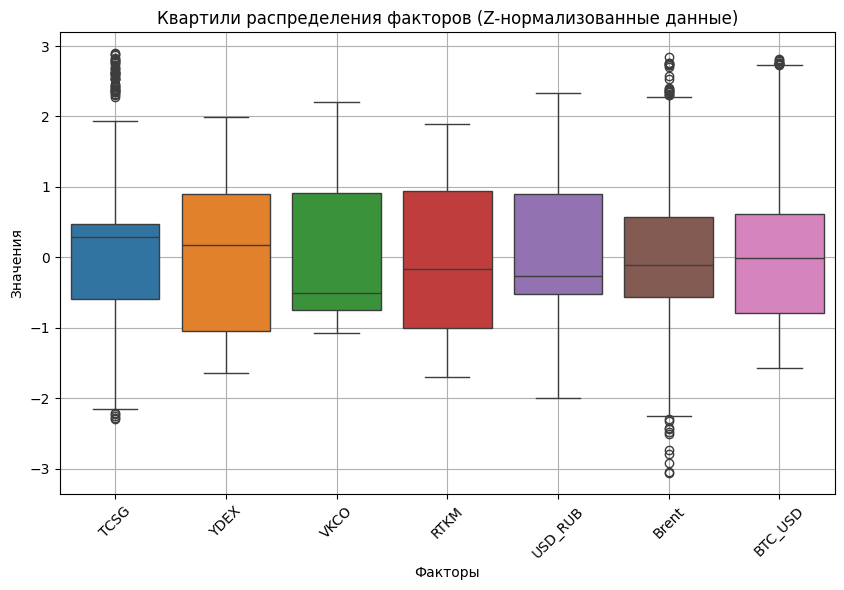


Предупреждение: Линейная регрессия может быть менее надежной из-за ненормального распределения данных. Рекомендуется рассмотреть нелинейные модели для повышения точности.

Результаты регрессии с пояснениями (на тестовой выборке):
Каждая строка показывает, как макроэкономические факторы влияют на цену акций компании.
- USD_RUB (β1): Влияние курса доллара к рублю (положительное или отрицательное).
- Brent (β2): Влияние цены нефти (обычно отрицательное для цифрового сектора).
- BTC_USD (β3): Влияние цены биткоина (положительное для TCSG и YDEX).
- Intercept: Базовая цена акций при нулевых факторах (Z-нормализована).
- MAE: Средняя абсолютная ошибка (чем меньше, тем точнее модель).
- MSE: Средняя квадратичная ошибка (показывает разброс ошибок).
Примечание: Регрессионные коэффициенты для USD_RUB противоречат корреляциям Спирмена, что указывает на нелинейные зависимости и может снижать точность линейной модели.
Компания  USD_RUB (β1)  Brent (β2)  BTC_USD (β3)  Intercept    MAE    MSE
    TC

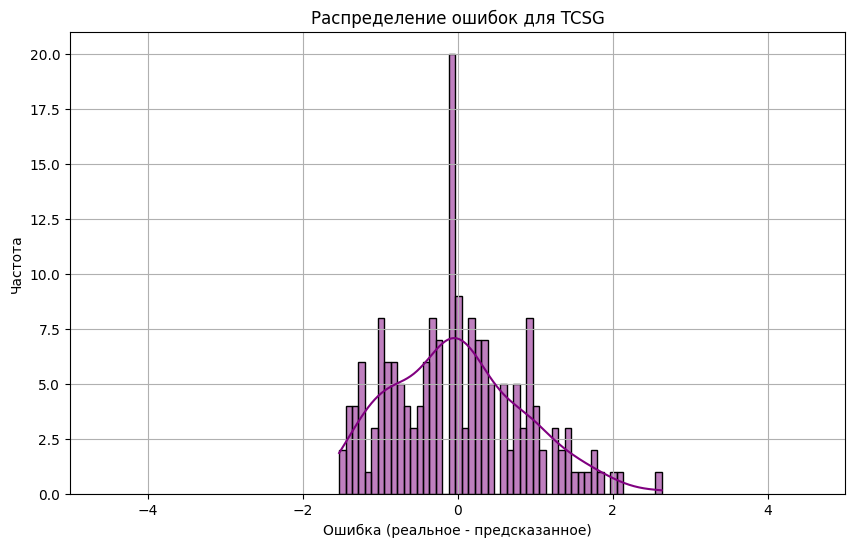


Характеристики ошибок для YDEX:
- Среднее: Ошибки в среднем смещены вниз (среднее: -0.1314).
- Стандартное отклонение: Умеренная вариабельность ошибок (стандартное отклонение: 0.8265). Умеренная вариабельность указывает на ограниченную точность модели, особенно для RTKM.
- Асимметрия: Ошибки симметричны (значение: 0.2077)
- Куртозис: Нормальные хвосты ошибок (значение: -0.8727)
- Шапиро-Уилка: stat=0.9718, p=0.0010, Ошибки не соответствуют нормальному распределению


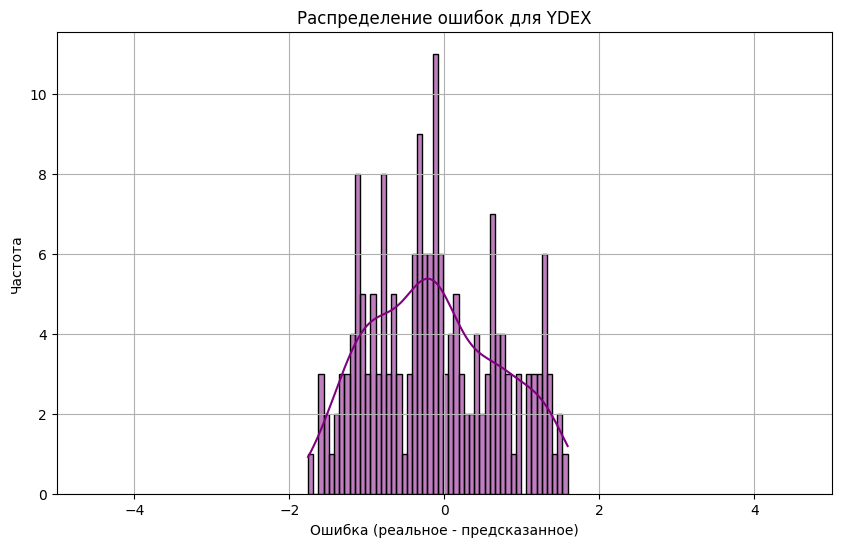


Характеристики ошибок для VKCO:
- Среднее: Ошибки в среднем смещены вниз (среднее: -0.1175).
- Стандартное отклонение: Умеренная вариабельность ошибок (стандартное отклонение: 0.8498). Умеренная вариабельность указывает на ограниченную точность модели, особенно для RTKM.
- Асимметрия: Ошибки симметричны (значение: 0.3861)
- Куртозис: Нормальные хвосты ошибок (значение: -0.8125)
- Шапиро-Уилка: stat=0.9600, p=0.0000, Ошибки не соответствуют нормальному распределению


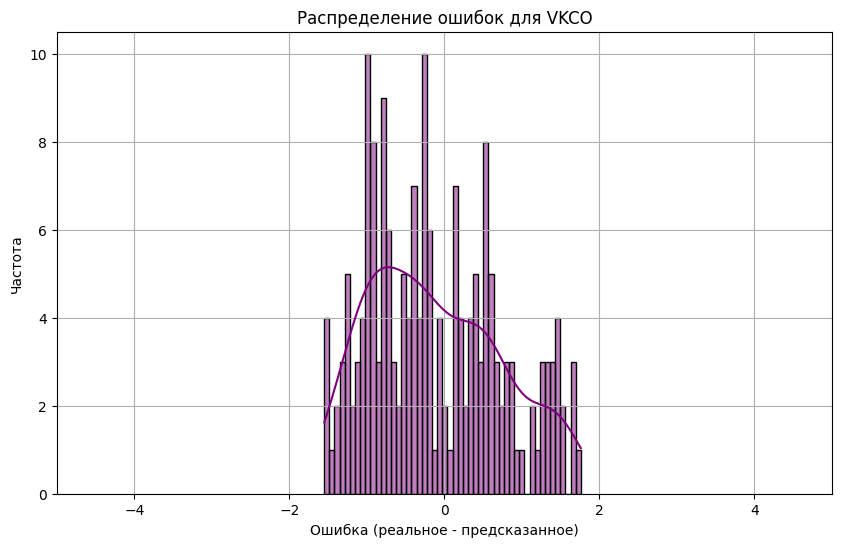


Характеристики ошибок для RTKM:
- Среднее: Ошибки в среднем смещены вниз (среднее: -0.1126).
- Стандартное отклонение: Умеренная вариабельность ошибок (стандартное отклонение: 0.9124). Умеренная вариабельность указывает на ограниченную точность модели, особенно для RTKM.
- Асимметрия: Ошибки симметричны (значение: -0.0767)
- Куртозис: Нормальные хвосты ошибок (значение: -0.8912)
- Шапиро-Уилка: stat=0.9692, p=0.0005, Ошибки не соответствуют нормальному распределению


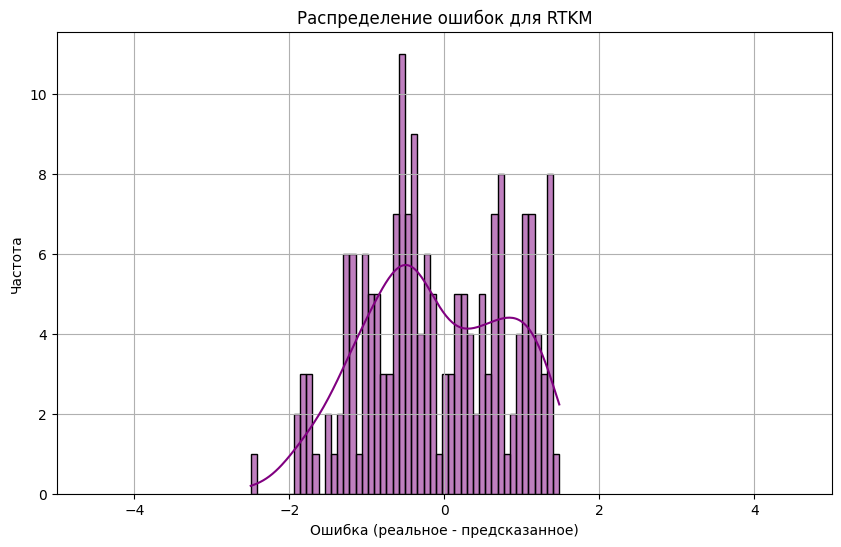


Вывод ANOVA с замечаниями:
Высокая остаточная дисперсия, особенно для RTKM, указывает на ограничения модели. Добавление факторов (например, процентных ставок) может улучшить объяснительную способность.
Для USD_RUB в RTKM (p=0.0373) значимость на грани (p ≈ 0.05), что требует осторожной интерпретации.

Результаты ANOVA для TCSG с пояснениями:
ANOVA показывает, насколько каждый фактор объясняет вариацию цен акций.
- Source: Фактор (USD_RUB, Brent, BTC_USD) или остаточная вариация (Residual).
- sum_sq: Доля вариации, объясненная фактором (чем больше, тем сильнее влияние).
- df: Степени свободы (1 для факторов, 904 для остатков).
- F: F-статистика (чем выше, тем значимее фактор).
- PR(>F): p-значение (если p < 0.05, фактор значим).
    sum_sq    df          F       PR(>F)
  6.957116   1.0  10.103657 1.530059e-03
 11.329882   1.0  16.454124 5.414477e-05
166.387671   1.0 241.640946 1.811740e-48
622.470889 904.0        NaN          NaN

Результаты ANOVA для YDEX с пояснениями:
ANOVA показыва

interactive(children=(Dropdown(description='Тип данных:', index=1, options=('Z-нормализованные', 'Реальные (ру…

<function __main__.update_sliders(data_type)>

In [ ]:


# Предполагаемые данные (замените на ваши cleaned_df и normalized_df)
# cleaned_df - ненормализованные данные в рублях
# normalized_df - Z-нормализованные данные

# Список переменных
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
independent_vars = ['USD_RUB', 'Brent', 'BTC_USD']

# 1. Проверка нормальности и характеристик распределения
factors = ['TCSG', 'YDEX', 'VKCO', 'RTKM', 'USD_RUB', 'Brent', 'BTC_USD']
normality_results = []
distribution_stats = []

for factor in factors:
    data = normalized_df[factor].dropna()
    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(data)
    conclusion = "Не соответствует нормальному распределению" if p_value < 0.05 else "Соответствует нормальному распределению"
    normality_results.append([factor, stat, p_value, conclusion])

    # Характеристики распределения
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    mean = data.mean()
    median = data.median()
    std = data.std()
    min_val = data.min()
    max_val = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    # Интерпретация асимметрии
    skewness_comment = (
        "Сильная правосторонняя асимметрия" if skewness > 1 else
        "Сильная левосторонняя асимметрия" if skewness < -1 else
        "Умеренная асимметрия" if abs(skewness) > 0.5 else
        "Приблизительно симметричное распределение"
    )
    
    # Интерпретация куртозиса
    kurtosis_comment = (
        "Тяжёлые хвосты (много выбросов)" if kurtosis > 3 else
        "Лёгкие хвосты (меньшая вероятность экстремальных значений, что положительно для моделирования)" if kurtosis < -1 else
        "Нормальные хвосты (умеренное количество выбросов)"
    )
    
    # Дополнительные комментарии для факторов
    factor_comment = (
        "Высокая волатильность из-за влияния криптовалютного рынка и санкций." if factor == 'TCSG' else
        "Зависимость от сырьевых рынков (нефть) и макроэкономической среды." if factor in ['YDEX', 'VKCO', 'RTKM'] else
        "Волатильность связана с экономическими и геополитическими факторами." if factor == 'USD_RUB' else
        "Зависимость от мировых сырьевых рынков." if factor == 'Brent' else
        "Высокая волатильность из-за спекулятивного характера криптовалют."
    )
    
    distribution_stats.append([
        factor, mean, median, std, skewness, kurtosis, min_val, max_val, q1, q3,
        skewness_comment, kurtosis_comment, factor_comment
    ])

# Формирование таблиц результатов
normality_df = pd.DataFrame(normality_results, columns=['Фактор', 'Статистика Шапиро-Уилка', 'p-value', 'Нормальность'])
dist_stats_df = pd.DataFrame(distribution_stats, columns=[
    'Фактор', 'Среднее', 'Медиана', 'Стд. откл.', 'Асимметрия', 'Куртозис',
    'Мин.', 'Макс.', 'Q1', 'Q3', 'Асимметрия (пояснение)', 'Куртозис (пояснение)', 'Комментарий'
]).round(4)

# Сохранение таблиц
normality_df.to_excel('normality_results.xlsx', index=False)
dist_stats_df.to_excel('distribution_stats.xlsx', index=False)

# Вывод таблиц
print("\nРезультаты теста Шапиро-Уилка:")
print(normality_df.to_string(index=False))
print("\nХарактеристики распределения:")
print(dist_stats_df.to_string(index=False))

# Boxplot для визуализации квартилей
plt.figure(figsize=(10, 6))
sns.boxplot(data=normalized_df[factors])
plt.title('Квартили распределения факторов (Z-нормализованные данные)')
plt.xlabel('Факторы')
plt.ylabel('Значения')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('boxplot_factors.png', bbox_inches='tight')
plt.show()

# 2. Модель регрессии на нормализованных данных с разбиением на обучающую и тестовую выборки
print("\nПредупреждение: Линейная регрессия может быть менее надежной из-за ненормального распределения данных. Рекомендуется рассмотреть нелинейные модели для повышения точности.")
results_normalized = {}
X_normalized = normalized_df[independent_vars].dropna()

for y_var in dependent_vars:
    y = normalized_df[y_var].dropna()
    common_index = X_normalized.index.intersection(y.index)
    X_subset = X_normalized.loc[common_index]
    y_subset = y.loc[common_index]
    
    # Разбиение данных на обучающую (80%) и тестовую (20%) выборки
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
    
    # Обучение модели на обучающей выборке
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Предсказания на тестовой выборке
    y_pred = model.predict(X_test)
    
    # Вычисление метрик на тестовой выборке
    mae = np.mean(np.abs(y_test - y_pred))
    mse = np.mean((y_test - y_pred) ** 2)
    
    results_normalized[y_var] = {
        'y_actual': y_test,
        'y_pred': y_pred,
        'X_test': X_test,
        'coefficients': dict(zip(independent_vars, model.coef_)),
        'intercept': model.intercept_,
        'MAE': mae,
        'MSE': mse
    }

# Формирование таблицы регрессии
results_data = []
for y_var in dependent_vars:
    coeffs = results_normalized[y_var]['coefficients']
    results_data.append([
        y_var,
        coeffs.get('USD_RUB', 0),
        coeffs.get('Brent', 0),
        coeffs.get('BTC_USD', 0),
        results_normalized[y_var]['intercept'],
        results_normalized[y_var]['MAE'],
        results_normalized[y_var]['MSE']
    ])
results_df = pd.DataFrame(
    results_data,
    columns=['Компания', 'USD_RUB (β1)', 'Brent (β2)', 'BTC_USD (β3)', 'Intercept', 'MAE', 'MSE']
).round(4)

# Вывод результатов регрессии с пояснениями
print("\nРезультаты регрессии с пояснениями (на тестовой выборке):")
print("Каждая строка показывает, как макроэкономические факторы влияют на цену акций компании.")
print("- USD_RUB (β1): Влияние курса доллара к рублю (положительное или отрицательное).")
print("- Brent (β2): Влияние цены нефти (обычно отрицательное для цифрового сектора).")
print("- BTC_USD (β3): Влияние цены биткоина (положительное для TCSG и YDEX).")
print("- Intercept: Базовая цена акций при нулевых факторах (Z-нормализована).")
print("- MAE: Средняя абсолютная ошибка (чем меньше, тем точнее модель).")
print("- MSE: Средняя квадратичная ошибка (показывает разброс ошибок).")
print("Примечание: Регрессионные коэффициенты для USD_RUB противоречат корреляциям Спирмена, что указывает на нелинейные зависимости и может снижать точность линейной модели.")
print(results_df.to_string(index=False))

# 3. Анализ ошибок регрессии
print("\nАнализ ошибок регрессии (на тестовой выборке):")
print("Симметричность и нормальные/лёгкие хвосты ошибок свидетельствуют, что модель хорошо предсказывает центральную часть данных, но может хуже улавливать экстремальные значения, что ожидаемо для линей eveniment на ненормальных данных.")
for y_var in dependent_vars:
    errors = results_normalized[y_var]['y_actual'] - results_normalized[y_var]['y_pred']
    error_mean = errors.mean()
    error_std = errors.std()
    error_skewness = stats.skew(errors)
    error_kurtosis = stats.kurtosis(errors)
    
    # Тест Шапиро-Уилка для ошибок
    stat, p = stats.shapiro(errors)
    normality_comment = "Ошибки не соответствуют нормальному распределению" if p < 0.05 else "Ошибки соответствуют нормальному распределению"
    
    # Интерпретация ошибок
    error_mean_comment = (
        f"Ошибки в среднем {'смещены вверх' if error_mean > 0.1 else 'смещены вниз' if error_mean < -0.1 else 'близки к нулю'} "
        f"(среднее: {error_mean:.4f})."
    )
    error_std_comment = (
        f"{'Высокая вариабельность ошибок' if error_std > 1 else 'Умеренная вариабельность ошибок' if error_std > 0.5 else 'Низкая вариабельность ошибок'} "
        f"(стандартное отклонение: {error_std:.4f}). Умеренная вариабельность указывает на ограниченную точность модели, особенно для RTKM."
    )
    error_skewness_comment = (
        "Сильная правосторонняя асимметрия ошибок" if error_skewness > 1 else
        "Сильная левосторонняя асимметрия ошибок" if error_skewness < -1 else
        "Умеренная асимметрия ошибок" if abs(error_skewness) > 0.5 else
        "Ошибки симметричны"
    )
    error_kurtosis_comment = (
        "Тяжёлые хвосты ошибок (много выбросов)" if error_kurtosis > 3 else
        "Лёгкие хвосты ошибок (меньшая вероятность экстремальных значений)" if error_kurtosis < -1 else
        "Нормальные хвосты ошибок"
    )
    
    # Вывод характеристик ошибок
    print(f"\nХарактеристики ошибок для {y_var}:")
    print(f"- Среднее: {error_mean_comment}")
    print(f"- Стандартное отклонение: {error_std_comment}")
    print(f"- Асимметрия: {error_skewness_comment} (значение: {error_skewness:.4f})")
    print(f"- Куртозис: {error_kurtosis_comment} (значение: {error_kurtosis:.4f})")
    print(f"- Шапиро-Уилка: stat={stat:.4f}, p={p:.4f}, {normality_comment}")
    
    # Гистограмма ошибок
    plt.figure()
    sns.histplot(errors, kde=True, bins=50, color='purple')
    plt.title(f'Распределение ошибок для {y_var}')
    plt.xlabel('Ошибка (реальное - предсказанное)')
    plt.ylabel('Частота')
    plt.xlim(-5, 5)
    plt.grid(True)
    plt.savefig(f'error_histogram_{y_var}.png', bbox_inches='tight')
    plt.show()

# 4. ANOVA анализ
print("\nВывод ANOVA с замечаниями:")
print("Высокая остаточная дисперсия, особенно для RTKM, указывает на ограничения модели. Добавление факторов (например, процентных ставок) может улучшить объяснительную способность.")
print("Для USD_RUB в RTKM (p=0.0373) значимость на грани (p ≈ 0.05), что требует осторожной интерпретации.")
results_anova = {}
for y_var in dependent_vars:
    data = normalized_df[[y_var] + independent_vars].dropna()
    formula = f'{y_var} ~ USD_RUB + Brent + BTC_USD'
    model = ols(formula, data=data).fit()
    anova_table = anova_lm(model, typ=2)
    results_anova[y_var] = anova_table

    print(f"\nРезультаты ANOVA для {y_var} с пояснениями:")
    print("ANOVA показывает, насколько каждый фактор объясняет вариацию цен акций.")
    print("- Source: Фактор (USD_RUB, Brent, BTC_USD) или остаточная вариация (Residual).")
    print("- sum_sq: Доля вариации, объясненная фактором (чем больше, тем сильнее влияние).")
    print("- df: Степени свободы (1 для факторов, 904 для остатков).")
    print("- F: F-статистика (чем выше, тем значимее фактор).")
    print("- PR(>F): p-значение (если p < 0.05, фактор значим).")
    print(results_anova[y_var].to_string(index=False))

# 5. Модель для ненормализованных данных (рублях) с разбиением на обучающую и тестовую выборки
def train_ruble_model():
    X_ruble = cleaned_df[independent_vars].dropna()
    results_ruble = {}
    
    for y_var in dependent_vars:
        y = cleaned_df[y_var].dropna()
        common_index = X_ruble.index.intersection(y.index)
        X_subset = X_ruble.loc[common_index]
        y_subset = y.loc[common_index]
        
        # Разбиение данных на обучающую (80%) и тестовую (20%) выборки
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
        
        # Обучение модели на обучающей выборке
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)
        
        # Вычисление метрик на тестовой выборке
        mae = np.mean(np.abs(y_test - y_pred))
        mse = np.mean((y_test - y_pred) ** 2)
        
        results_ruble[y_var] = {
            'y_actual': y_test,
            'y_pred': y_pred,
            'X_test': X_test,
            'coefficients': dict(zip(independent_vars, model.coef_)),
            'intercept': model.intercept_,
            'MAE': mae,
            'MSE': mse
        }
    return results_ruble

results_ruble = train_ruble_model()

# 6. Интерактивная визуализация с переключателем
def predict_prices(usd_rub, brent, btc_usd, data_type):
    predictions = {}
    if data_type == 'Z-нормализованные':
        results = results_normalized
        # Нормализация факторов
        usd_rub_norm = (usd_rub - cleaned_df['USD_RUB'].mean()) / cleaned_df['USD_RUB'].std()
        brent_norm = (brent - cleaned_df['Brent'].mean()) / cleaned_df['Brent'].std()
        btc_usd_norm = (btc_usd - cleaned_df['BTC_USD'].mean()) / cleaned_df['BTC_USD'].std()
        ylabel = 'Цена акций (Z-нормализованная)'
    else:
        results = results_ruble
        usd_rub_norm = usd_rub
        brent_norm = brent
        btc_usd_norm = btc_usd
        ylabel = 'Цена акций (рубли)'
    
    for y_var in dependent_vars:
        model_coefs = results[y_var]['coefficients']
        intercept = results[y_var]['intercept']
        prediction = (intercept +
                      model_coefs['USD_RUB'] * usd_rub_norm +
                      model_coefs['Brent'] * brent_norm +
                      model_coefs['BTC_USD'] * btc_usd_norm)
        if data_type == 'Реальные (рубли)':
            prediction = max(0, prediction)  # Цены акций не могут быть отрицательными
        predictions[y_var] = prediction
    return predictions, ylabel, usd_rub_norm, brent_norm, btc_usd_norm

def update_plot(usd_rub, brent, btc_usd, data_type):
    try:
        predictions, ylabel, usd_rub_norm, brent_norm, btc_usd_norm = predict_prices(usd_rub, brent, btc_usd, data_type)
        print(f"\nПредсказания ({data_type}):", {k: round(v, 2) for k, v in predictions.items()})
        
        # Визуализация барплота
        plt.figure()
        companies = list(predictions.keys())
        values = [predictions[company] for company in companies]
        bars = plt.bar(companies, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title(f'Прогнозируемые цены акций ({data_type})', fontsize=14)
        plt.xlabel('Компания')
        plt.ylabel(ylabel)
        plt.grid(True, axis='y')
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, value + 0.02 * value, f'{value:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(f'prediction_{data_type.lower().replace(" ", "_")}_barplot.png', bbox_inches='tight')
        plt.show()

        # Отладочный вывод коэффициентов
        print(f"\nКоэффициенты модели ({data_type}):")
        for y_var in dependent_vars:
            results = results_normalized if data_type == 'Z-нормализованные' else results_ruble[y_var]
            print(f"{y_var}:")
            print(f"  USD_RUB: {results['coefficients']['USD_RUB']:.4f}")
            print(f"  Brent: {results['coefficients']['Brent']:.4f}")
            print(f"  BTC_USD: {results['coefficients']['BTC_USD']:.4f}")
            print(f"  Intercept: {results['intercept']:.4f}")
    except Exception as e:
        print(f"Ошибка в интерактивной визуализации: {e}")

# Ползунки для реальных данных
usd_rub_slider_ruble = FloatSlider(
    min=cleaned_df['USD_RUB'].min(), max=cleaned_df['USD_RUB'].max(), step=0.1,
    value=cleaned_df['USD_RUB'].mean(), description='USD/RUB (рубли):'
)
brent_slider_ruble = FloatSlider(
    min=cleaned_df['Brent'].min(), max=cleaned_df['Brent'].max(), step=0.1,
    value=cleaned_df['Brent'].mean(), description='Brent (долл./барр.):'
)
btc_usd_slider_ruble = FloatSlider(
    min=cleaned_df['BTC_USD'].min(), max=150000, step=100,
    value=cleaned_df['BTC_USD'].mean(), description='BTC/USD (долл.):'
)

# Вычисление нового диапазона для Z-нормализованного BTC_USD
btc_mean = cleaned_df['BTC_USD'].mean()
btc_std = cleaned_df['BTC_USD'].std()
btc_max_norm = (150000 - btc_mean) / btc_std  # Новый максимум в Z-нормализованных единицах
btc_min_norm = (cleaned_df['BTC_USD'].min() - btc_mean) / btc_std

# Ползунки для Z-нормализованных данных
usd_rub_slider_norm = FloatSlider(
    min=normalized_df['USD_RUB'].min(), max=normalized_df['USD_RUB'].max(), step=0.1,
    value=normalized_df['USD_RUB'].mean(), description='USD/RUB (Z-норм):'
)
brent_slider_norm = FloatSlider(
    min=normalized_df['Brent'].min(), max=normalized_df['Brent'].max(), step=0.1,
    value=normalized_df['Brent'].mean(), description='Brent (Z-норм):'
)
btc_usd_slider_norm = FloatSlider(
    min=btc_min_norm, max=btc_max_norm, step=0.1,
    value=normalized_df['BTC_USD'].mean(), description='BTC/USD (Z-норм):'
)

# Переключатель типа данных
data_type_dropdown = Dropdown(
    options=['Z-нормализованные', 'Реальные (рубли)'],
    value='Реальные (рубли)',
    description='Тип данных:'
)

def update_sliders(data_type):
    if data_type == 'Z-нормализованные':
        interact(
            update_plot,
            usd_rub=usd_rub_slider_norm,
            brent=brent_slider_norm,
            btc_usd=btc_usd_slider_norm,
            data_type=fixed(data_type)
        )
    else:
        interact(
            update_plot,
            usd_rub=usd_rub_slider_ruble,
            brent=brent_slider_ruble,
            btc_usd=btc_usd_slider_ruble,
            data_type=fixed(data_type)
        )

interact(update_sliders, data_type=data_type_dropdown)


Результаты теста Шапиро-Уилка:
 Фактор  Статистика Шапиро-Уилка      p-value                               Нормальность
   TCSG                 0.962388 1.556980e-14 Не соответствует нормальному распределению
   YDEX                 0.922211 3.117971e-21 Не соответствует нормальному распределению
   VKCO                 0.817431 7.383052e-31 Не соответствует нормальному распределению
   RTKM                 0.928064 1.910697e-20 Не соответствует нормальному распределению
USD_RUB                 0.957361 1.362451e-15 Не соответствует нормальному распределению
  Brent                 0.977189 1.009165e-10 Не соответствует нормальному распределению
BTC_USD                 0.960226 5.320527e-15 Не соответствует нормальному распределению

Характеристики распределения:
 Фактор  Среднее  Медиана  Стд. откл.  Асимметрия  Куртозис    Мин.  Макс.      Q1     Q3                    Асимметрия (пояснение)                                       Куртозис (пояснение)                                   

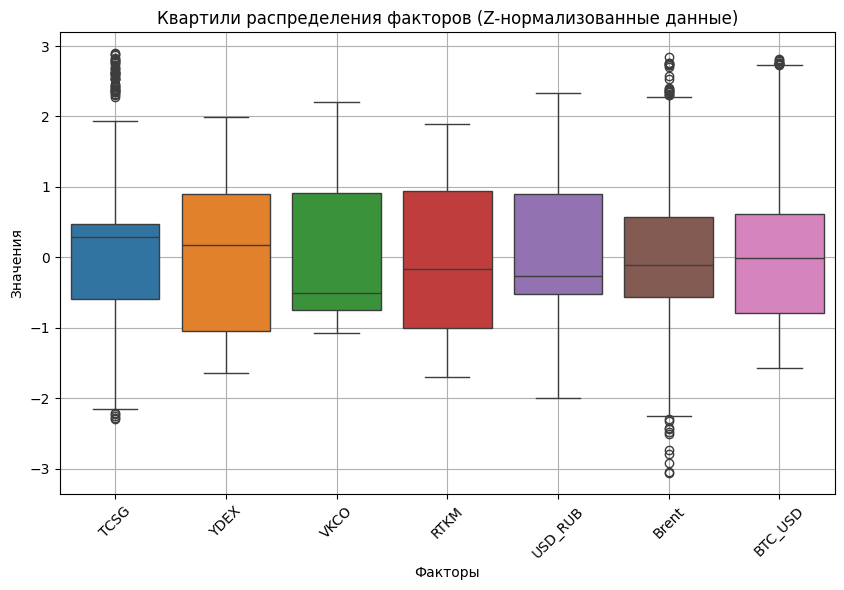


Предупреждение: Линейная регрессия может быть менее надежной из-за ненормального распределения данных. Случайный лес может лучше улавливать нелинейные зависимости.

Результаты линейной регрессии (на тестовой выборке):
Компания  USD_RUB (β1)  Brent (β2)  BTC_USD (β3)  Intercept    MAE    MSE
    TCSG        0.0944     -0.1067        0.4693     0.0020 0.6715 0.7097
    YDEX       -0.0918     -0.4055        0.3265     0.0263 0.6992 0.6966
    VKCO       -0.1953     -0.4503       -0.2014     0.0236 0.7338 0.7320
    RTKM       -0.0311     -0.3340        0.2298     0.0226 0.7867 0.8406

Результаты случайного леса (на тестовой выборке):
Компания  USD_RUB (важность)  Brent (важность)  BTC_USD (важность)    MAE    MSE
    TCSG              0.1476            0.2599              0.5925 0.1807 0.0919
    YDEX              0.3868            0.1110              0.5022 0.2436 0.1467
    VKCO              0.3768            0.1608              0.4624 0.1079 0.0535
    RTKM              0.5199        

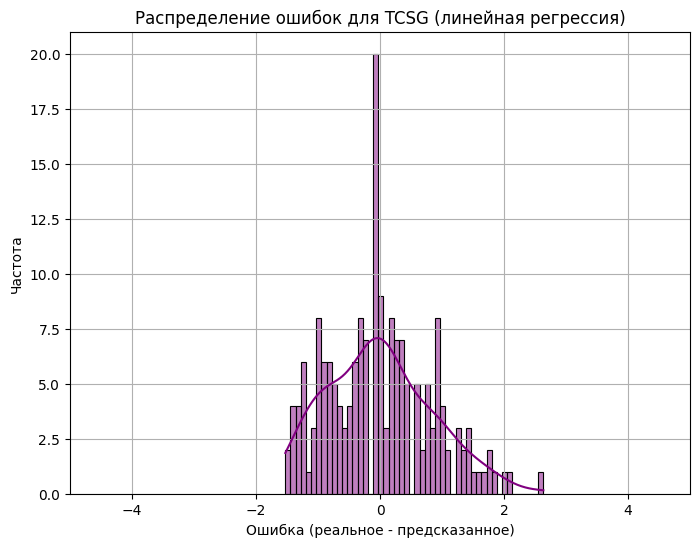

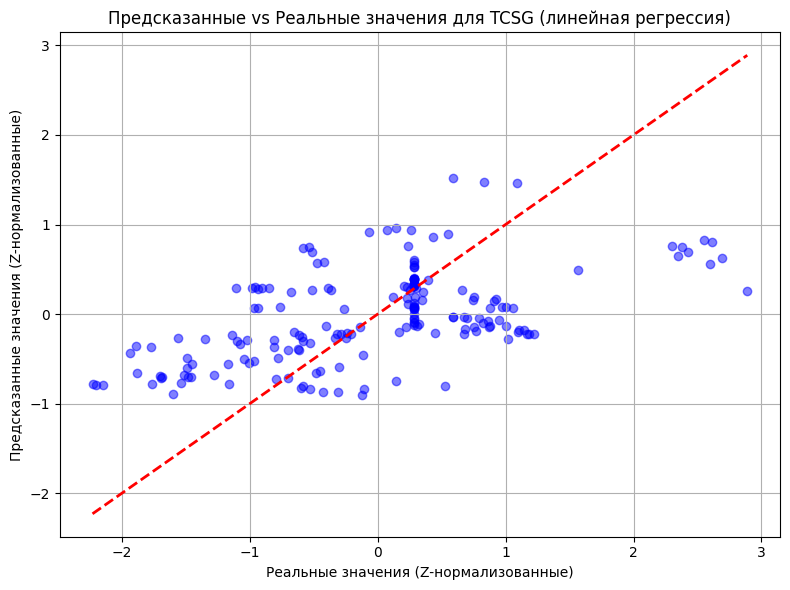


Характеристики ошибок для YDEX (линейная регрессия):
- Среднее: Ошибки в среднем смещены вниз (среднее: -0.1314).
- Стандартное отклонение: Умеренная вариабельность ошибок (стандартное отклонение: 0.8265).
- Асимметрия: Ошибки симметричны (значение: 0.2077)
- Куртозис: Нормальные хвосты ошибок (значение: -0.8727)
- Шапиро-Уилка: stat=0.9718, p=0.0010, Ошибки не соответствуют нормальному распределению


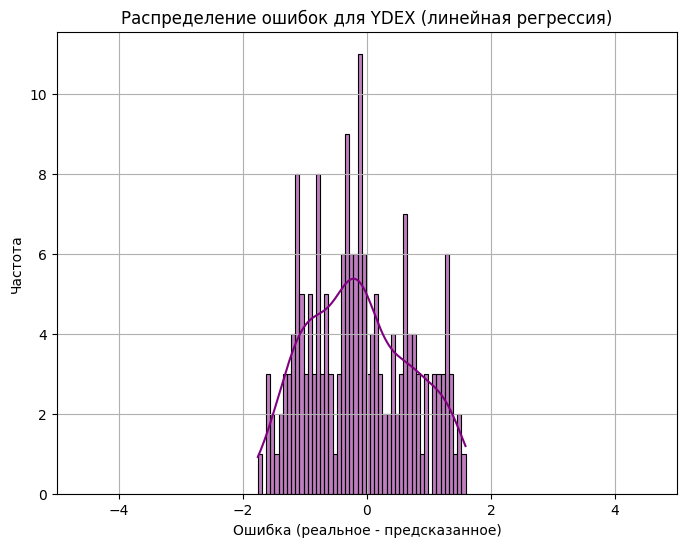

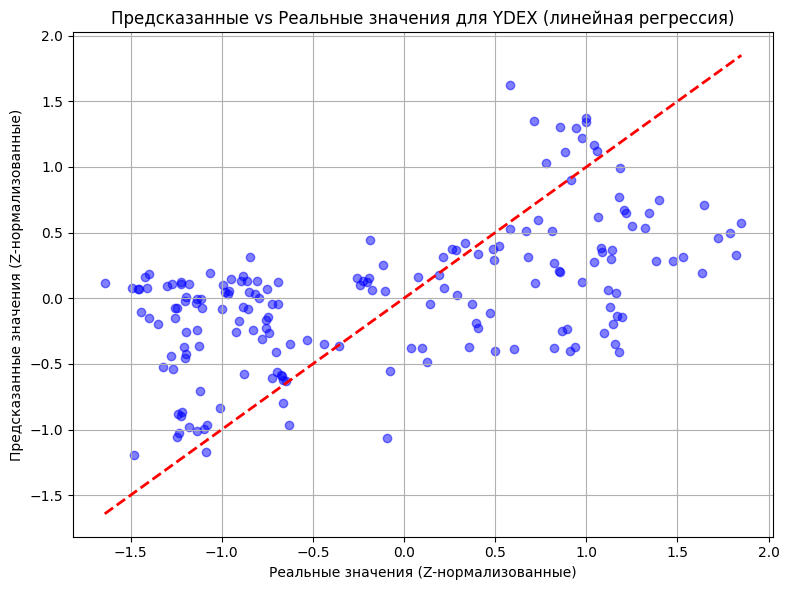


Характеристики ошибок для VKCO (линейная регрессия):
- Среднее: Ошибки в среднем смещены вниз (среднее: -0.1175).
- Стандартное отклонение: Умеренная вариабельность ошибок (стандартное отклонение: 0.8498).
- Асимметрия: Ошибки симметричны (значение: 0.3861)
- Куртозис: Нормальные хвосты ошибок (значение: -0.8125)
- Шапиро-Уилка: stat=0.9600, p=0.0000, Ошибки не соответствуют нормальному распределению


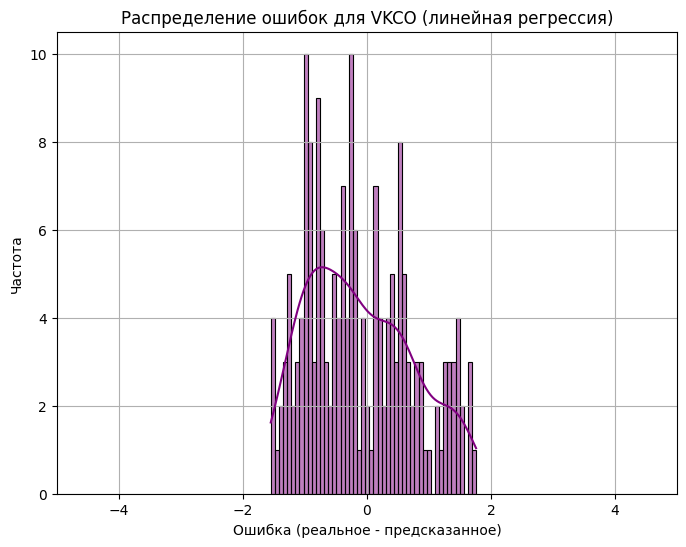

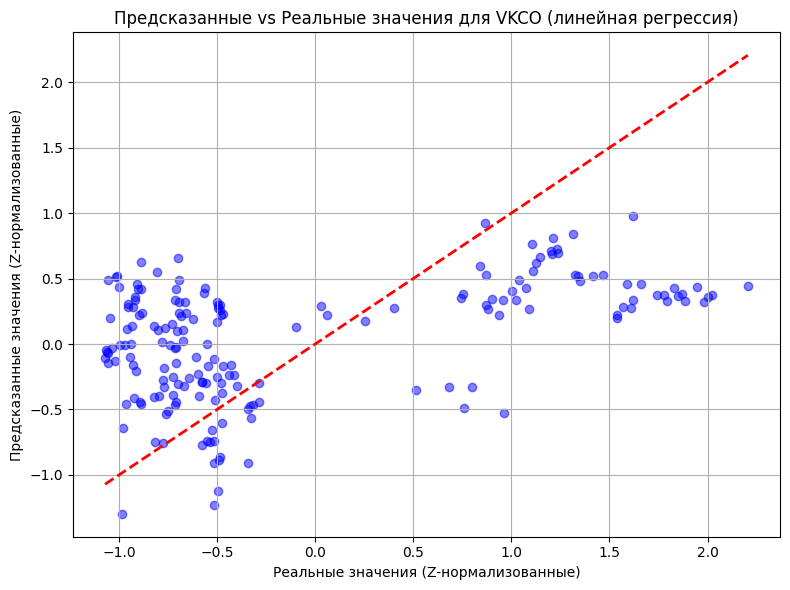


Характеристики ошибок для RTKM (линейная регрессия):
- Среднее: Ошибки в среднем смещены вниз (среднее: -0.1126).
- Стандартное отклонение: Умеренная вариабельность ошибок (стандартное отклонение: 0.9124).
- Асимметрия: Ошибки симметричны (значение: -0.0767)
- Куртозис: Нормальные хвосты ошибок (значение: -0.8912)
- Шапиро-Уилка: stat=0.9692, p=0.0005, Ошибки не соответствуют нормальному распределению


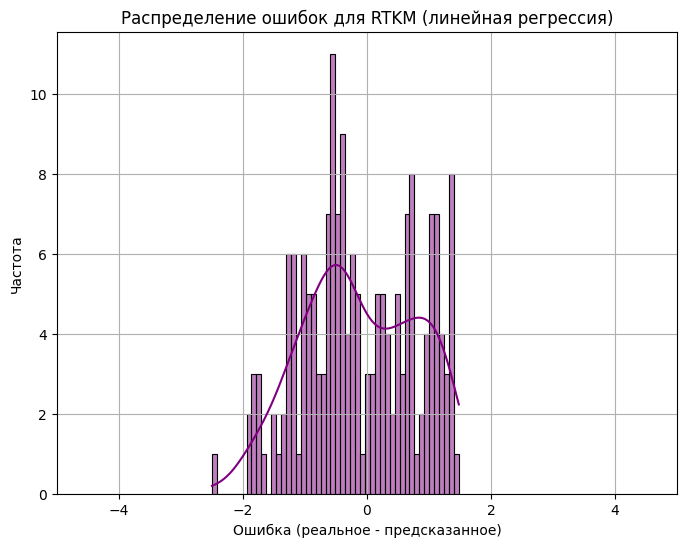

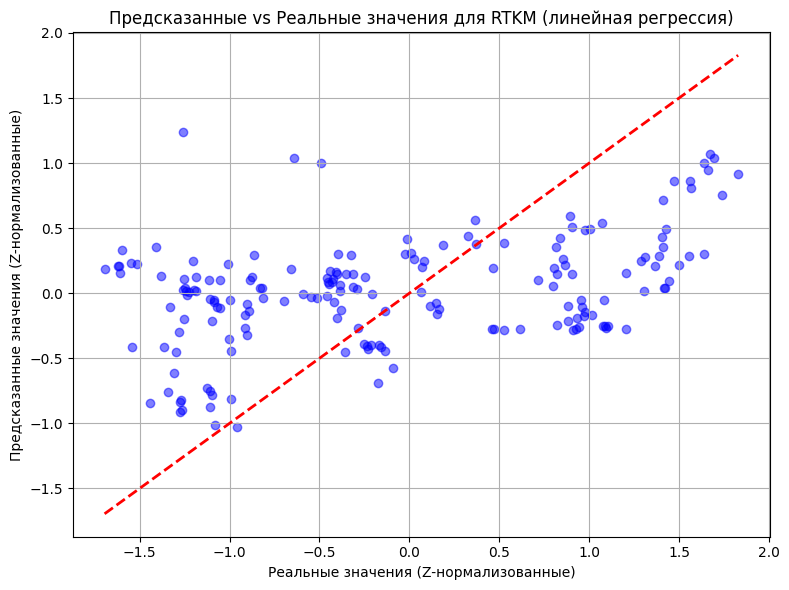


Анализ ошибок случайного леса (на тестовой выборке):

Характеристики ошибок для TCSG (случайный лес):
- Среднее: Ошибки в среднем близки к нулю (среднее: -0.0079).
- Стандартное отклонение: Низкая вариабельность ошибок (стандартное отклонение: 0.3039).
- Асимметрия: Сильная правосторонняя асимметрия ошибок (значение: 1.1373)
- Куртозис: Тяжёлые хвосты ошибок (много выбросов) (значение: 8.0561)
- Шапиро-Уилка: stat=0.8299, p=0.0000, Ошибки не соответствуют нормальному распределению


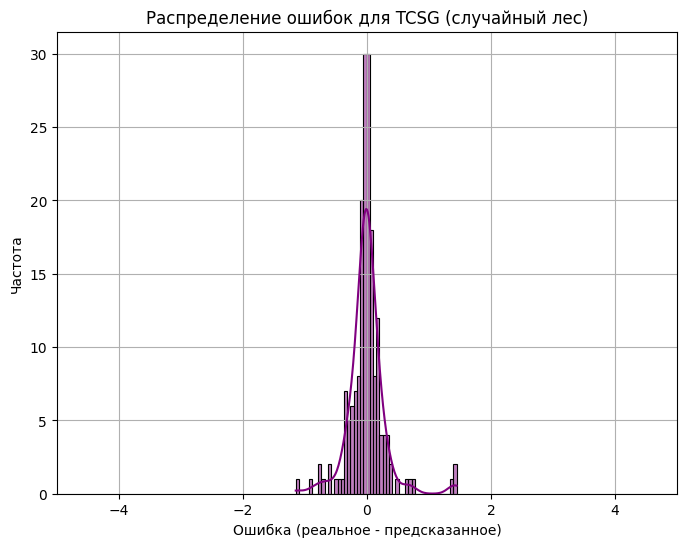

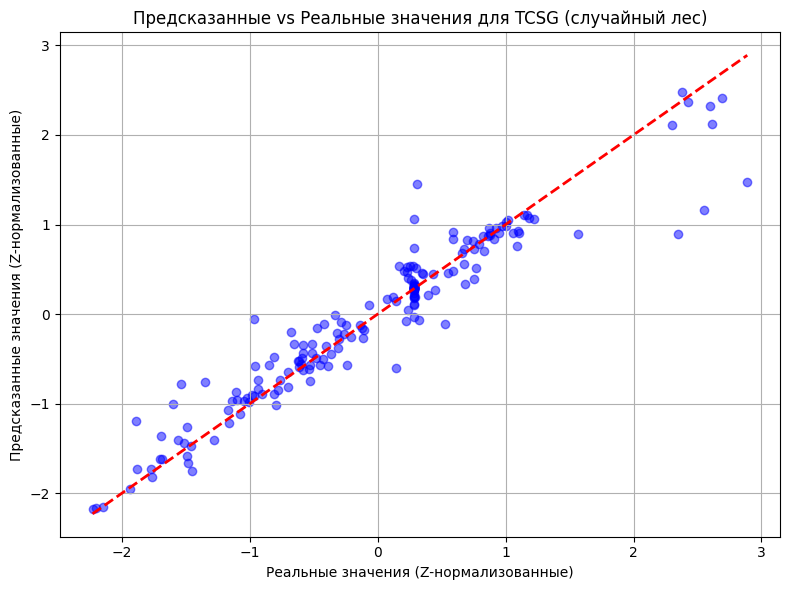


Характеристики ошибок для YDEX (случайный лес):
- Среднее: Ошибки в среднем близки к нулю (среднее: -0.0311).
- Стандартное отклонение: Низкая вариабельность ошибок (стандартное отклонение: 0.3828).
- Асимметрия: Ошибки симметричны (значение: -0.2939)
- Куртозис: Тяжёлые хвосты ошибок (много выбросов) (значение: 3.3058)
- Шапиро-Уилка: stat=0.9076, p=0.0000, Ошибки не соответствуют нормальному распределению


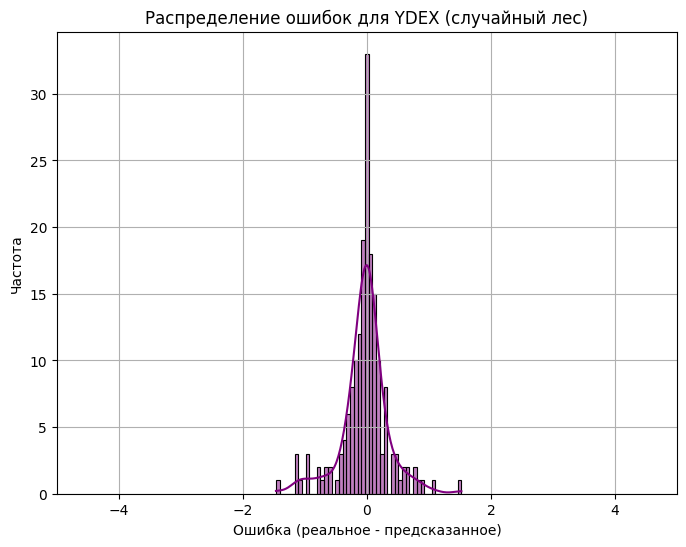

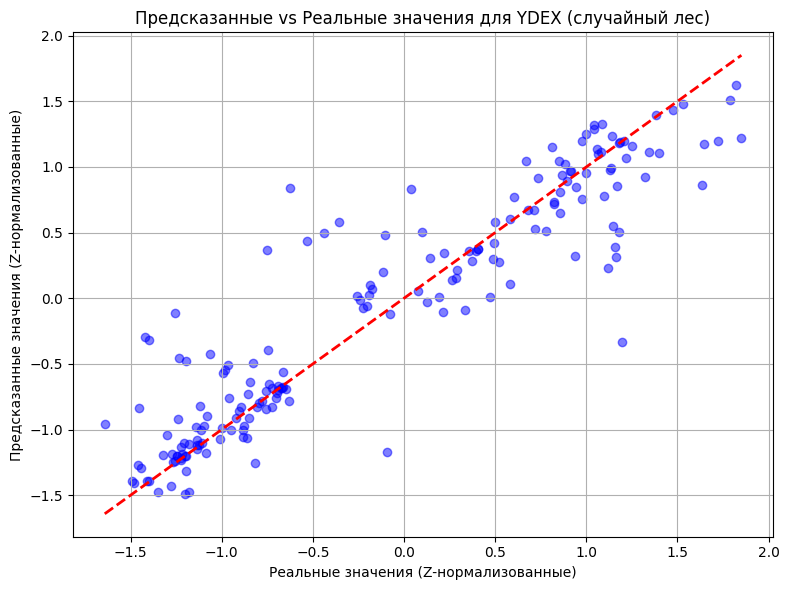


Характеристики ошибок для VKCO (случайный лес):
- Среднее: Ошибки в среднем близки к нулю (среднее: -0.0181).
- Стандартное отклонение: Низкая вариабельность ошибок (стандартное отклонение: 0.2313).
- Асимметрия: Сильная левосторонняя асимметрия ошибок (значение: -3.3339)
- Куртозис: Тяжёлые хвосты ошибок (много выбросов) (значение: 21.8732)
- Шапиро-Уилка: stat=0.6463, p=0.0000, Ошибки не соответствуют нормальному распределению


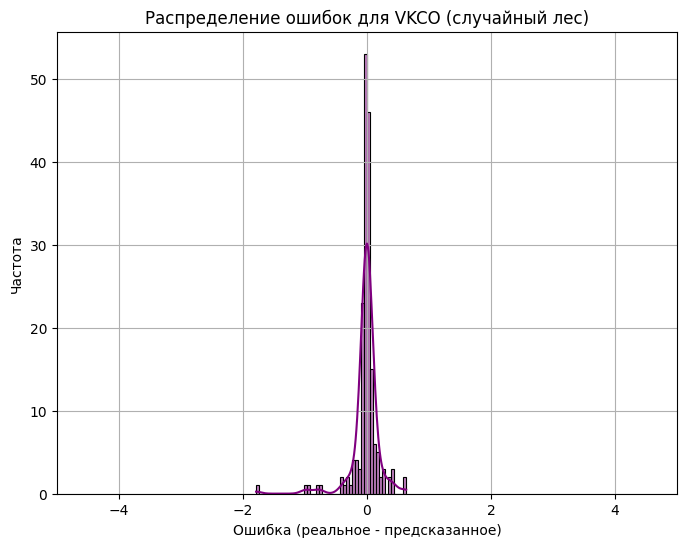

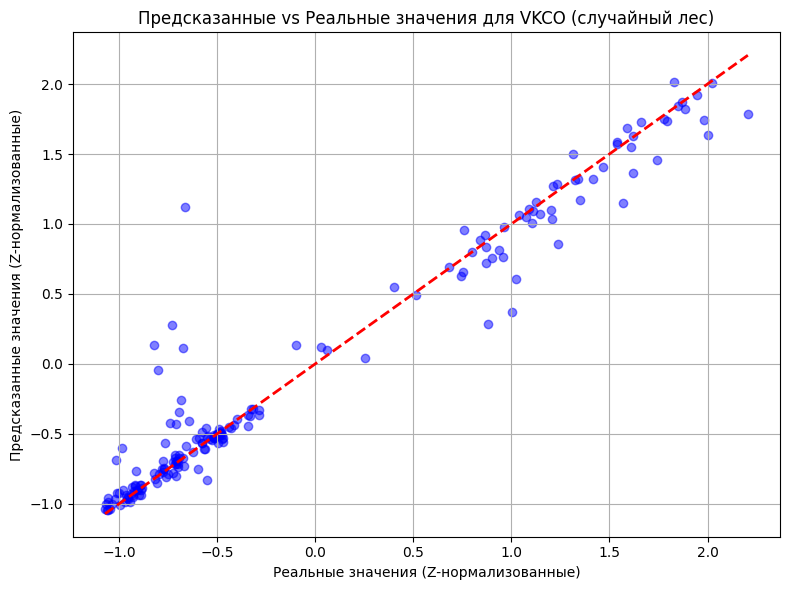


Характеристики ошибок для RTKM (случайный лес):
- Среднее: Ошибки в среднем близки к нулю (среднее: 0.0069).
- Стандартное отклонение: Низкая вариабельность ошибок (стандартное отклонение: 0.2992).
- Асимметрия: Ошибки симметричны (значение: -0.3898)
- Куртозис: Тяжёлые хвосты ошибок (много выбросов) (значение: 15.5013)
- Шапиро-Уилка: stat=0.7187, p=0.0000, Ошибки не соответствуют нормальному распределению


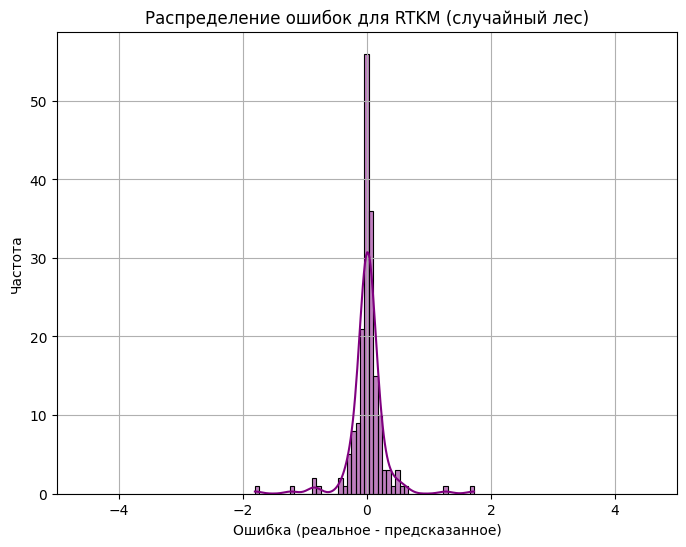

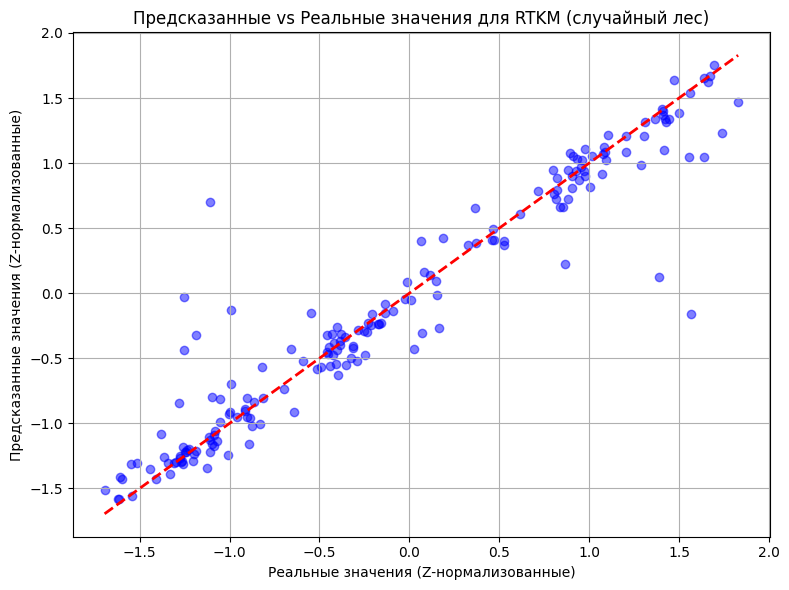


Вывод ANOVA для линейной регрессии:

Результаты ANOVA для TCSG:
    sum_sq    df          F       PR(>F)
  6.957116   1.0  10.103657 1.530059e-03
 11.329882   1.0  16.454124 5.414477e-05
166.387671   1.0 241.640946 1.811740e-48
622.470889 904.0        NaN          NaN

Результаты ANOVA для YDEX:
    sum_sq    df          F       PR(>F)
  8.604484   1.0  12.491397 4.295570e-04
137.211768   1.0 199.194604 5.042460e-41
 84.482683   1.0 122.646147 8.083367e-27
622.704810 904.0        NaN          NaN

Результаты ANOVA для VKCO:
    sum_sq    df          F       PR(>F)
 36.702359   1.0  48.789193 5.522941e-12
168.277905   1.0 223.695243 2.347186e-45
 26.504357   1.0  35.232781 4.166220e-09
680.046767 904.0        NaN          NaN

Результаты ANOVA для RTKM:
    sum_sq    df          F       PR(>F)
  3.512442   1.0   4.350914 3.726897e-02
 92.649752   1.0 114.766620 2.707268e-25
 45.382266   1.0  56.215685 1.548932e-13
729.788641 904.0        NaN          NaN


interactive(children=(Dropdown(description='Тип данных:', index=1, options=('Z-нормализованные', 'Реальные (ру…

<function __main__.update_sliders(data_type, model_type)>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from ipywidgets import interact, FloatSlider, Dropdown, fixed
from IPython.display import display

# Предполагаемые данные (cleaned_df и normalized_df)
# Список переменных
dependent_vars = ['TCSG', 'YDEX', 'VKCO', 'RTKM']
independent_vars = ['USD_RUB', 'Brent', 'BTC_USD']

# 1. Проверка нормальности и характеристик распределения
factors = ['TCSG', 'YDEX', 'VKCO', 'RTKM', 'USD_RUB', 'Brent', 'BTC_USD']
normality_results = []
distribution_stats = []

for factor in factors:
    data = normalized_df[factor].dropna()
    stat, p_value = stats.shapiro(data)
    conclusion = "Не соответствует нормальному распределению" if p_value < 0.05 else "Соответствует нормальному распределению"
    normality_results.append([factor, stat, p_value, conclusion])

    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    mean = data.mean()
    median = data.median()
    std = data.std()
    min_val = data.min()
    max_val = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    skewness_comment = (
        "Сильная правосторонняя асимметрия" if skewness > 1 else
        "Сильная левосторонняя асимметрия" if skewness < -1 else
        "Умеренная асимметрия" if abs(skewness) > 0.5 else
        "Приблизительно симметричное распределение"
    )
    
    kurtosis_comment = (
        "Тяжёлые хвосты (много выбросов)" if kurtosis > 3 else
        "Лёгкие хвосты (меньшая вероятность экстремальных значений)" if kurtosis < -1 else
        "Нормальные хвосты (умеренное количество выбросов)"
    )
    
    factor_comment = (
        "Высокая волатильность из-за влияния криптовалютного рынка и санкций." if factor == 'TCSG' else
        "Зависимость от сырьевых рынков (нефть) и макроэкономической среды." if factor in ['YDEX', 'VKCO', 'RTKM'] else
        "Волатильность связана с экономическими и геополитическими факторами." if factor == 'USD_RUB' else
        "Зависимость от мировых сырьевых рынков." if factor == 'Brent' else
        "Высокая волатильность из-за спекулятивного характера криптовалют."
    )
    
    distribution_stats.append([
        factor, mean, median, std, skewness, kurtosis, min_val, max_val, q1, q3,
        skewness_comment, kurtosis_comment, factor_comment
    ])

normality_df = pd.DataFrame(normality_results, columns=['Фактор', 'Статистика Шапиро-Уилка', 'p-value', 'Нормальность'])
dist_stats_df = pd.DataFrame(distribution_stats, columns=[
    'Фактор', 'Среднее', 'Медиана', 'Стд. откл.', 'Асимметрия', 'Куртозис',
    'Мин.', 'Макс.', 'Q1', 'Q3', 'Асимметрия (пояснение)', 'Куртозис (пояснение)', 'Комментарий'
]).round(4)

normality_df.to_excel('normality_results.xlsx', index=False)
dist_stats_df.to_excel('distribution_stats.xlsx', index=False)

print("\nРезультаты теста Шапиро-Уилка:")
print(normality_df.to_string(index=False))
print("\nХарактеристики распределения:")
print(dist_stats_df.to_string(index=False))

plt.figure(figsize=(10, 6))
sns.boxplot(data=normalized_df[factors])
plt.title('Квартили распределения факторов (Z-нормализованные данные)')
plt.xlabel('Факторы')
plt.ylabel('Значения')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('boxplot_factors.png', bbox_inches='tight')
plt.show()

# 2. Модель регрессии и случайного леса на нормализованных данных
print("\nПредупреждение: Линейная регрессия может быть менее надежной из-за ненормального распределения данных. Случайный лес может лучше улавливать нелинейные зависимости.")
results_normalized = {}  # Линейная регрессия
results_normalized_rf = {}  # Случайный лес
X_normalized = normalized_df[independent_vars].dropna()

for y_var in dependent_vars:
    y = normalized_df[y_var].dropna()
    common_index = X_normalized.index.intersection(y.index)
    X_subset = X_normalized.loc[common_index]
    y_subset = y.loc[common_index]
    
    # Разбиение данных
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
    
    # Линейная регрессия
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    mae_lr = np.mean(np.abs(y_test - y_pred_lr))
    mse_lr = np.mean((y_test - y_pred_lr) ** 2)
    
    results_normalized[y_var] = {
        'y_actual': y_test,
        'y_pred': y_pred_lr,
        'X_test': X_test,
        'coefficients': dict(zip(independent_vars, model_lr.coef_)),
        'intercept': model_lr.intercept_,
        'MAE': mae_lr,
        'MSE': mse_lr
    }
    
    # Случайный лес
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    mae_rf = np.mean(np.abs(y_test - y_pred_rf))
    mse_rf = np.mean((y_test - y_pred_rf) ** 2)
    
    results_normalized_rf[y_var] = {
        'y_actual': y_test,
        'y_pred': y_pred_rf,
        'X_test': X_test,
        'feature_importances': dict(zip(independent_vars, model_rf.feature_importances_)),
        'MAE': mae_rf,
        'MSE': mse_rf
    }

# Формирование таблицы регрессии (линейная регрессия)
results_data = []
for y_var in dependent_vars:
    coeffs = results_normalized[y_var]['coefficients']
    results_data.append([
        y_var,
        coeffs.get('USD_RUB', 0),
        coeffs.get('Brent', 0),
        coeffs.get('BTC_USD', 0),
        results_normalized[y_var]['intercept'],
        results_normalized[y_var]['MAE'],
        results_normalized[y_var]['MSE']
    ])
results_df = pd.DataFrame(
    results_data,
    columns=['Компания', 'USD_RUB (β1)', 'Brent (β2)', 'BTC_USD (β3)', 'Intercept', 'MAE', 'MSE']
).round(4)

print("\nРезультаты линейной регрессии (на тестовой выборке):")
print(results_df.to_string(index=False))

# Формирование таблицы для случайного леса
results_data_rf = []
for y_var in dependent_vars:
    importances = results_normalized_rf[y_var]['feature_importances']
    results_data_rf.append([
        y_var,
        importances.get('USD_RUB', 0),
        importances.get('Brent', 0),
        importances.get('BTC_USD', 0),
        results_normalized_rf[y_var]['MAE'],
        results_normalized_rf[y_var]['MSE']
    ])
results_df_rf = pd.DataFrame(
    results_data_rf,
    columns=['Компания', 'USD_RUB (важность)', 'Brent (важность)', 'BTC_USD (важность)', 'MAE', 'MSE']
).round(4)

print("\nРезультаты случайного леса (на тестовой выборке):")
print(results_df_rf.to_string(index=False))

# 3. Анализ ошибок регрессии
print("\nАнализ ошибок линейной регрессии (на тестовой выборке):")
for y_var in dependent_vars:
    errors = results_normalized[y_var]['y_actual'] - results_normalized[y_var]['y_pred']
    error_mean = errors.mean()
    error_std = errors.std()
    error_skewness = stats.skew(errors)
    error_kurtosis = stats.kurtosis(errors)
    
    stat, p = stats.shapiro(errors)
    normality_comment = "Ошибки не соответствуют нормальному распределению" if p < 0.05 else "Ошибки соответствуют нормальному распределению"
    
    error_mean_comment = (
        f"Ошибки в среднем {'смещены вверх' if error_mean > 0.1 else 'смещены вниз' if error_mean < -0.1 else 'близки к нулю'} "
        f"(среднее: {error_mean:.4f})."
    )
    error_std_comment = (
        f"{'Высокая вариабельность ошибок' if error_std > 1 else 'Умеренная вариабельность ошибок' if error_std > 0.5 else 'Низкая вариабельность ошибок'} "
        f"(стандартное отклонение: {error_std:.4f})."
    )
    error_skewness_comment = (
        "Сильная правосторонняя асимметрия ошибок" if error_skewness > 1 else
        "Сильная левосторонняя асимметрия ошибок" if error_skewness < -1 else
        "Умеренная асимметрия ошибок" if abs(error_skewness) > 0.5 else
        "Ошибки симметричны"
    )
    error_kurtosis_comment = (
        "Тяжёлые хвосты ошибок (много выбросов)" if error_kurtosis > 3 else
        "Лёгкие хвосты ошибок (меньшая вероятность экстремальных значений)" if error_kurtosis < -1 else
        "Нормальные хвосты ошибок"
    )
    
    print(f"\nХарактеристики ошибок для {y_var} (линейная регрессия):")
    print(f"- Среднее: {error_mean_comment}")
    print(f"- Стандартное отклонение: {error_std_comment}")
    print(f"- Асимметрия: {error_skewness_comment} (значение: {error_skewness:.4f})")
    print(f"- Куртозис: {error_kurtosis_comment} (значение: {error_kurtosis:.4f})")
    print(f"- Шапиро-Уилка: stat={stat:.4f}, p={p:.4f}, {normality_comment}")
    
    # Гистограмма ошибок
    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True, bins=50, color='purple')
    plt.title(f'Распределение ошибок для {y_var} (линейная регрессия)')
    plt.xlabel('Ошибка (реальное - предсказанное)')
    plt.ylabel('Частота')
    plt.xlim(-5, 5)
    plt.grid(True)
    plt.savefig(f'error_histogram_{y_var}_lr.png', bbox_inches='tight')
    plt.show()
    
    # График предсказанных vs реальных значений
    y_actual = results_normalized[y_var]['y_actual']
    y_pred = results_normalized[y_var]['y_pred']
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, color='blue', alpha=0.5)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.title(f'Предсказанные vs Реальные значения для {y_var} (линейная регрессия)')
    plt.xlabel('Реальные значения (Z-нормализованные)')
    plt.ylabel('Предсказанные значения (Z-нормализованные)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'scatter_{y_var}_lr_normalized.png', bbox_inches='tight')
    plt.show()

# Анализ ошибок случайного леса
print("\nАнализ ошибок случайного леса (на тестовой выборке):")
for y_var in dependent_vars:
    errors = results_normalized_rf[y_var]['y_actual'] - results_normalized_rf[y_var]['y_pred']
    error_mean = errors.mean()
    error_std = errors.std()
    error_skewness = stats.skew(errors)
    error_kurtosis = stats.kurtosis(errors)
    
    stat, p = stats.shapiro(errors)
    normality_comment = "Ошибки не соответствуют нормальному распределению" if p < 0.05 else "Ошибки соответствуют нормальному распределению"
    
    error_mean_comment = (
        f"Ошибки в среднем {'смещены вверх' if error_mean > 0.1 else 'смещены вниз' if error_mean < -0.1 else 'близки к нулю'} "
        f"(среднее: {error_mean:.4f})."
    )
    error_std_comment = (
        f"{'Высокая вариабельность ошибок' if error_std > 1 else 'Умеренная вариабельность ошибок' if error_std > 0.5 else 'Низкая вариабельность ошибок'} "
        f"(стандартное отклонение: {error_std:.4f})."
    )
    error_skewness_comment = (
        "Сильная правосторонняя асимметрия ошибок" if error_skewness > 1 else
        "Сильная левосторонняя асимметрия ошибок" if error_skewness < -1 else
        "Умеренная асимметрия ошибок" if abs(error_skewness) > 0.5 else
        "Ошибки симметричны"
    )
    error_kurtosis_comment = (
        "Тяжёлые хвосты ошибок (много выбросов)" if error_kurtosis > 3 else
        "Лёгкие хвосты ошибок (меньшая вероятность экстремальных значений)" if error_kurtosis < -1 else
        "Нормальные хвосты ошибок"
    )
    
    print(f"\nХарактеристики ошибок для {y_var} (случайный лес):")
    print(f"- Среднее: {error_mean_comment}")
    print(f"- Стандартное отклонение: {error_std_comment}")
    print(f"- Асимметрия: {error_skewness_comment} (значение: {error_skewness:.4f})")
    print(f"- Куртозис: {error_kurtosis_comment} (значение: {error_kurtosis:.4f})")
    print(f"- Шапиро-Уилка: stat={stat:.4f}, p={p:.4f}, {normality_comment}")
    
    # Гистограмма ошибок
    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True, bins=50, color='purple')
    plt.title(f'Распределение ошибок для {y_var} (случайный лес)')
    plt.xlabel('Ошибка (реальное - предсказанное)')
    plt.ylabel('Частота')
    plt.xlim(-5, 5)
    plt.grid(True)
    plt.savefig(f'error_histogram_{y_var}_rf.png', bbox_inches='tight')
    plt.show()
    
    # График предсказанных vs реальных значений
    y_actual = results_normalized_rf[y_var]['y_actual']
    y_pred = results_normalized_rf[y_var]['y_pred']
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, color='blue', alpha=0.5)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.title(f'Предсказанные vs Реальные значения для {y_var} (случайный лес)')
    plt.xlabel('Реальные значения (Z-нормализованные)')
    plt.ylabel('Предсказанные значения (Z-нормализованные)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'scatter_{y_var}_rf_normalized.png', bbox_inches='tight')
    plt.show()

# 4. ANOVA анализ (только для линейной регрессии)
print("\nВывод ANOVA для линейной регрессии:")
results_anova = {}
for y_var in dependent_vars:
    data = normalized_df[[y_var] + independent_vars].dropna()
    formula = f'{y_var} ~ USD_RUB + Brent + BTC_USD'
    model = ols(formula, data=data).fit()
    anova_table = anova_lm(model, typ=2)
    results_anova[y_var] = anova_table

    print(f"\nРезультаты ANOVA для {y_var}:")
    print(results_anova[y_var].to_string(index=False))

# 5. Модель для ненормализованных данных (рубли)
def train_ruble_model():
    X_ruble = cleaned_df[independent_vars].dropna()
    results_ruble = {}  # Линейная регрессия
    results_ruble_rf = {}  # Случайный лес
    
    for y_var in dependent_vars:
        y = cleaned_df[y_var].dropna()
        common_index = X_ruble.index.intersection(y.index)
        X_subset = X_ruble.loc[common_index]
        y_subset = y.loc[common_index]
        
        # Разбиение данных
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
        
        # Линейная регрессия
        model_lr = LinearRegression()
        model_lr.fit(X_train, y_train)
        y_pred_lr = model_lr.predict(X_test)
        mae_lr = np.mean(np.abs(y_test - y_pred_lr))
        mse_lr = np.mean((y_test - y_pred_lr) ** 2)
        
        results_ruble[y_var] = {
            'y_actual': y_test,
            'y_pred': y_pred_lr,
            'X_test': X_test,
            'coefficients': dict(zip(independent_vars, model_lr.coef_)),
            'intercept': model_lr.intercept_,
            'MAE': mae_lr,
            'MSE': mse_lr
        }
        
        # Случайный лес
        model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
        model_rf.fit(X_train, y_train)
        y_pred_rf = model_rf.predict(X_test)
        mae_rf = np.mean(np.abs(y_test - y_pred_rf))
        mse_rf = np.mean((y_test - y_pred_rf) ** 2)
        
        results_ruble_rf[y_var] = {
            'y_actual': y_test,
            'y_pred': y_pred_rf,
            'X_test': X_test,
            'feature_importances': dict(zip(independent_vars, model_rf.feature_importances_)),
            'MAE': mae_rf,
            'MSE': mse_rf
        }
    
    return results_ruble, results_ruble_rf

results_ruble, results_ruble_rf = train_ruble_model()

# 6. Интерактивная визуализация
def predict_prices(usd_rub, brent, btc_usd, data_type, model_type):
    predictions = {}
    if data_type == 'Z-нормализованные':
        results = results_normalized if model_type == 'Линейная регрессия' else results_normalized_rf
        usd_rub_norm = (usd_rub - cleaned_df['USD_RUB'].mean()) / cleaned_df['USD_RUB'].std()
        brent_norm = (brent - cleaned_df['Brent'].mean()) / cleaned_df['Brent'].std()
        btc_usd_norm = (btc_usd - cleaned_df['BTC_USD'].mean()) / cleaned_df['BTC_USD'].std()
        ylabel = 'Цена акций (Z-нормализованная)'
    else:
        results = results_ruble if model_type == 'Линейная регрессия' else results_ruble_rf
        usd_rub_norm = usd_rub
        brent_norm = brent
        btc_usd_norm = btc_usd
        ylabel = 'Цена акций (рубли)'
    
    for y_var in dependent_vars:
        if model_type == 'Линейная регрессия':
            model_coefs = results[y_var]['coefficients']
            intercept = results[y_var]['intercept']
            prediction = (intercept +
                          model_coefs['USD_RUB'] * usd_rub_norm +
                          model_coefs['Brent'] * brent_norm +
                          model_coefs['BTC_USD'] * btc_usd_norm)
        else:
            # Для случайного леса используем предсказание модели
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(results[y_var]['X_test'], results[y_var]['y_actual'])
            prediction = model.predict([[usd_rub_norm, brent_norm, btc_usd_norm]])[0]
        
        if data_type == 'Реальные (рубли)':
            prediction = max(0, prediction)
        predictions[y_var] = prediction
    return predictions, ylabel

def update_plot(usd_rub, brent, btc_usd, data_type, model_type):
    try:
        predictions, ylabel = predict_prices(usd_rub, brent, btc_usd, data_type, model_type)
        print(f"\nПредсказания ({data_type}, {model_type}):", {k: round(v, 2) for k, v in predictions.items()})
        
        # Барплот предсказаний
        plt.figure(figsize=(8, 6))
        companies = list(predictions.keys())
        values = [predictions[company] for company in companies]
        bars = plt.bar(companies, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title(f'Прогнозируемые цены акций ({data_type}, {model_type})', fontsize=14)
        plt.xlabel('Компания')
        plt.ylabel(ylabel)
        plt.grid(True, axis='y')
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, value + 0.02 * value, f'{value:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(f'prediction_{data_type.lower().replace(" ", "_")}_{model_type.lower().replace(" ", "_")}_barplot.png', bbox_inches='tight')
        plt.show()

        # Отладочный вывод
        results = (
            results_normalized if data_type == 'Z-нормализованные' and model_type == 'Линейная регрессия' else
            results_normalized_rf if data_type == 'Z-нормализованные' and model_type == 'Случайный лес' else
            results_ruble if data_type == 'Реальные (рубли)' and model_type == 'Линейная регрессия' else
            results_ruble_rf
        )
        print(f"\nРезультаты модели ({data_type}, {model_type}):")
        for y_var in dependent_vars:
            print(f"{y_var}:")
            if model_type == 'Линейная регрессия':
                print(f"  USD_RUB: {results[y_var]['coefficients']['USD_RUB']:.2f}")
                print(f"  Brent: {results[y_var]['coefficients']['Brent']:.2f}")
                print(f"  BTC_USD: {results[y_var]['coefficients']['BTC_USD']:.2f}")
                print(f"  Intercept: {results[y_var]['intercept']:.2f}")
            else:
                print(f"  USD_RUB importance: {results[y_var]['feature_importances']['USD_RUB']:.2f}")
                print(f"  Brent importance: {results[y_var]['feature_importances']['Brent']:.2f}")
                print(f"  BTC_USD importance: {results[y_var]['feature_importances']['BTC_USD']:.2f}")
            print(f"  MAE: {results[y_var]['MAE']:.4f}")
            print(f"  MSE: {results[y_var]['MSE']:.4f}")

    except Exception as e:
        print(f"Ошибка в интерактивной визуализации: {e}")

# Ползунки для реальных данных
usd_rub_slider_ruble = FloatSlider(
    min=cleaned_df['USD_RUB'].min(), max=cleaned_df['USD_RUB'].max(), step=0.1,
    value=cleaned_df['USD_RUB'].mean(), description='USD/RUB (руб):'
)
brent_slider_ruble = FloatSlider(
    min=cleaned_df['Brent'].min(), max=cleaned_df['Brent'].max(), step=0.1,
    value=cleaned_df['Brent'].mean(), description='Brent (долл.):'
)
btc_usd_slider_ruble = FloatSlider(
    min=cleaned_df['BTC_USD'].min(), max=150000, step=100,
    value=cleaned_df['BTC_USD'].mean(), description='BTC/USD (долл.):'
)

# Ползунки для Z-нормализованных данных
btc_mean = cleaned_df['BTC_USD'].mean()
btc_std = cleaned_df['BTC_USD'].std()
btc_max_norm = (150000 - btc_mean) / btc_std
btc_min_norm = (cleaned_df['BTC_USD'].min() - btc_mean) / btc_std

usd_rub_slider_norm = FloatSlider(
    min=normalized_df['USD_RUB'].min(), max=normalized_df['USD_RUB'].max(), step=0.1,
    value=normalized_df['USD_RUB'].mean(), description='USD/RUB (Z-норм):'
)
brent_slider_norm = FloatSlider(
    min=normalized_df['Brent'].min(), max=normalized_df['Brent'].max(), step=0.1,
    value=normalized_df['Brent'].mean(), description='Brent (Z-норм):'
)
btc_usd_slider_norm = FloatSlider(
    min=btc_min_norm, max=btc_max_norm, step=0.1,
    value=normalized_df['BTC_USD'].mean(), description='BTC/USD (Z-норм):'
)

# Переключатели
data_type_dropdown = Dropdown(
    options=['Z-нормализованные', 'Реальные (рубли)'],
    value='Реальные (рубли)',
    description='Тип данных:'
)
model_type_dropdown = Dropdown(
    options=['Линейная регрессия', 'Случайный лес'],
    value='Линейная регрессия',
    description='Модель:'
)

def update_sliders(data_type, model_type):
    if data_type == 'Z-нормализованные':
        interact(
            update_plot,
            usd_rub=usd_rub_slider_norm,
            brent=brent_slider_norm,
            btc_usd=btc_usd_slider_norm,
            data_type=fixed(data_type),
            model_type=fixed(model_type)
        )
    else:
        interact(
            update_plot,
            usd_rub=usd_rub_slider_ruble,
            brent=brent_slider_ruble,
            btc_usd=btc_usd_slider_ruble,
            data_type=fixed(data_type),
            model_type=fixed(model_type)
        )

interact(update_sliders, data_type=data_type_dropdown, model_type=model_type_dropdown)